In [1]:
import xml.etree.ElementTree as ET
import pandas as pd
import pickle
import json
from datetime import datetime
from collections import defaultdict
import os

print("Libraries imported successfully")

Libraries imported successfully


In [2]:
# Define file paths
export_xml_path = 'data/apple_health_export/export.xml'
export_cda_path = 'data/apple_health_export/export_cda.xml'

# Check file sizes
export_size = os.path.getsize(export_xml_path) / (1024**2)  # Size in MB
cda_size = os.path.getsize(export_cda_path) / (1024**2)

print(f"export.xml size: {export_size:.2f} MB")
print(f"export_cda.xml size: {cda_size:.2f} MB")

export.xml size: 76.87 MB
export_cda.xml size: 35.30 MB


# Parsing export.xml
This file contains the main health data including:
- Records (heart rate, steps, sleep, etc.)
- Workouts
- Activity summaries
- Clinical records

In [3]:
def parse_export_xml(file_path):
    """
    Parse the export.xml file and extract all health data into structured dictionaries
    """
    print("Parsing export.xml... This may take a while due to file size.")
    
    # Initialize data structures
    data = {
        'records': [],
        'workouts': [],
        'activity_summary': [],
        'clinical_records': [],
        'me_record': {},
        'export_date': None
    }
    
    # Use iterparse for memory efficiency with large files
    context = ET.iterparse(file_path, events=('start', 'end'))
    context = iter(context)
    event, root = next(context)
    
    record_count = 0
    workout_count = 0
    activity_count = 0
    
    for event, elem in context:
        if event == 'end':
            # Extract Me record (personal info)
            if elem.tag == 'Me':
                data['me_record'] = dict(elem.attrib)
            
            # Extract export date
            elif elem.tag == 'ExportDate':
                data['export_date'] = elem.attrib.get('value')
            
            # Extract health records
            elif elem.tag == 'Record':
                data['records'].append(dict(elem.attrib))
                record_count += 1
                if record_count % 10000 == 0:
                    print(f"Processed {record_count} records...")
            
            # Extract workouts
            elif elem.tag == 'Workout':
                workout_data = dict(elem.attrib)
                # Get workout metadata
                metadata = []
                for child in elem:
                    if child.tag == 'MetadataEntry':
                        metadata.append(dict(child.attrib))
                    elif child.tag == 'WorkoutStatistics':
                        workout_data['statistics'] = dict(child.attrib)
                if metadata:
                    workout_data['metadata'] = metadata
                data['workouts'].append(workout_data)
                workout_count += 1
            
            # Extract activity summaries
            elif elem.tag == 'ActivitySummary':
                data['activity_summary'].append(dict(elem.attrib))
                activity_count += 1
            
            # Extract clinical records
            elif elem.tag == 'ClinicalRecord':
                data['clinical_records'].append(dict(elem.attrib))
            
            # Clear the element to free memory
            elem.clear()
            root.clear()
    
    print(f"\nParsing complete!")
    print(f"Total records: {record_count}")
    print(f"Total workouts: {workout_count}")
    print(f"Total activity summaries: {activity_count}")
    print(f"Total clinical records: {len(data['clinical_records'])}")
    
    return data

# Parse export.xml
export_data = parse_export_xml(export_xml_path)

Parsing export.xml... This may take a while due to file size.
Processed 10000 records...
Processed 20000 records...
Processed 30000 records...
Processed 40000 records...
Processed 50000 records...
Processed 60000 records...
Processed 70000 records...
Processed 80000 records...
Processed 90000 records...
Processed 100000 records...
Processed 110000 records...
Processed 120000 records...
Processed 130000 records...
Processed 140000 records...
Processed 150000 records...
Processed 160000 records...
Processed 170000 records...

Parsing complete!
Total records: 177161
Total workouts: 27
Total activity summaries: 185
Total clinical records: 0


In [4]:
# Display summary of parsed data
print("=== Export Data Summary ===")
print(f"Export Date: {export_data['export_date']}")
print(f"\nPersonal Info:")
for key, value in export_data['me_record'].items():
    print(f"  {key}: {value}")

print(f"\nTotal Health Records: {len(export_data['records'])}")
print(f"Total Workouts: {len(export_data['workouts'])}")
print(f"Total Activity Summaries: {len(export_data['activity_summary'])}")
print(f"Total Clinical Records: {len(export_data['clinical_records'])}")

# Show sample record types
if export_data['records']:
    record_types = {}
    for record in export_data['records']:
        rec_type = record.get('type', 'Unknown')
        record_types[rec_type] = record_types.get(rec_type, 0) + 1
    
    print(f"\nRecord Types Found ({len(record_types)} unique types):")
    # Show top 20 most common types
    sorted_types = sorted(record_types.items(), key=lambda x: x[1], reverse=True)[:20]
    for rec_type, count in sorted_types:
        print(f"  {rec_type}: {count}")

=== Export Data Summary ===
Export Date: 2025-12-23 12:16:20 +0100

Personal Info:
  HKCharacteristicTypeIdentifierDateOfBirth: 1983-10-27
  HKCharacteristicTypeIdentifierBiologicalSex: HKBiologicalSexMale
  HKCharacteristicTypeIdentifierBloodType: HKBloodTypeNotSet
  HKCharacteristicTypeIdentifierFitzpatrickSkinType: HKFitzpatrickSkinTypeNotSet
  HKCharacteristicTypeIdentifierCardioFitnessMedicationsUse: None

Total Health Records: 177161
Total Workouts: 27
Total Activity Summaries: 185
Total Clinical Records: 0

Record Types Found (39 unique types):
  HKQuantityTypeIdentifierHeartRate: 31398
  HKQuantityTypeIdentifierPhysicalEffort: 30157
  HKQuantityTypeIdentifierBasalEnergyBurned: 23180
  HKQuantityTypeIdentifierActiveEnergyBurned: 18626
  HKQuantityTypeIdentifierDistanceWalkingRunning: 17743
  HKQuantityTypeIdentifierStepCount: 10565
  HKQuantityTypeIdentifierWalkingSpeed: 8767
  HKQuantityTypeIdentifierWalkingStepLength: 8767
  HKQuantityTypeIdentifierWalkingDoubleSupportPercenta

# Parsing export_cda.xml
This is the Clinical Document Architecture (CDA) format, containing structured clinical data.

In [5]:
def parse_export_cda_xml(file_path):
    """
    Parse the export_cda.xml file (Clinical Document Architecture format)
    """
    print("Parsing export_cda.xml...")
    
    # Parse the XML tree
    tree = ET.parse(file_path)
    root = tree.getroot()
    
    # Define namespace
    ns = {'cda': 'urn:hl7-org:v3'}
    
    # Initialize data structure
    cda_data = {
        'document_info': {},
        'patient_info': {},
        'vital_signs': [],
        'results': [],
        'procedures': [],
        'medications': [],
        'immunizations': [],
        'allergies': []
    }
    
    # Extract document metadata
    title = root.find('.//cda:title', ns)
    if title is not None:
        cda_data['document_info']['title'] = title.text
    
    effective_time = root.find('.//cda:effectiveTime', ns)
    if effective_time is not None:
        cda_data['document_info']['effective_time'] = effective_time.get('value')
    
    # Extract patient information
    patient = root.find('.//cda:patient', ns)
    if patient is not None:
        gender = patient.find('.//cda:administrativeGenderCode', ns)
        if gender is not None:
            cda_data['patient_info']['gender'] = gender.get('displayName')
        
        birth_time = patient.find('.//cda:birthTime', ns)
        if birth_time is not None:
            cda_data['patient_info']['birth_date'] = birth_time.get('value')
    
    # Extract vital signs (observations)
    print("Extracting vital signs and observations...")
    observations = root.findall('.//cda:observation', ns)
    obs_count = 0
    
    for obs in observations:
        obs_data = {}
        
        # Get code (type of observation)
        code = obs.find('.//cda:code', ns)
        if code is not None:
            obs_data['code'] = code.get('code')
            obs_data['display_name'] = code.get('displayName')
        
        # Get value
        value = obs.find('.//cda:value', ns)
        if value is not None:
            obs_data['value'] = value.get('value')
            obs_data['unit'] = value.get('unit')
        
        # Get time
        effective_time = obs.find('.//cda:effectiveTime/cda:low', ns)
        if effective_time is not None:
            obs_data['time'] = effective_time.get('value')
        
        # Get source from text element
        text = obs.find('.//cda:text', ns)
        if text is not None:
            for child in text:
                if child.tag.endswith('sourceName'):
                    obs_data['source_name'] = child.text
                elif child.tag.endswith('sourceVersion'):
                    obs_data['source_version'] = child.text
                elif child.tag.endswith('type'):
                    obs_data['type'] = child.text
        
        if obs_data:
            cda_data['vital_signs'].append(obs_data)
            obs_count += 1
            if obs_count % 10000 == 0:
                print(f"Processed {obs_count} observations...")
    
    print(f"\nParsing complete!")
    print(f"Total observations/vital signs: {len(cda_data['vital_signs'])}")
    
    return cda_data

# Parse export_cda.xml
cda_data = parse_export_cda_xml(export_cda_path)

Parsing export_cda.xml...
Extracting vital signs and observations...
Processed 10000 observations...
Processed 20000 observations...
Processed 30000 observations...

Parsing complete!
Total observations/vital signs: 32078


In [6]:
# Display summary of CDA data
print("=== CDA Data Summary ===")
print(f"Document Info:")
for key, value in cda_data['document_info'].items():
    print(f"  {key}: {value}")

print(f"\nPatient Info:")
for key, value in cda_data['patient_info'].items():
    print(f"  {key}: {value}")

print(f"\nTotal Vital Signs/Observations: {len(cda_data['vital_signs'])}")

# Show sample observation types
if cda_data['vital_signs']:
    obs_types = {}
    for obs in cda_data['vital_signs']:
        obs_type = obs.get('type', obs.get('display_name', 'Unknown'))
        obs_types[obs_type] = obs_types.get(obs_type, 0) + 1
    
    print(f"\nObservation Types Found ({len(obs_types)} unique types):")
    # Show top 20 most common types
    sorted_types = sorted(obs_types.items(), key=lambda x: x[1], reverse=True)[:20]
    for obs_type, count in sorted_types:
        print(f"  {obs_type}: {count}")

=== CDA Data Summary ===
Document Info:
  title: Health Data Export
  effective_time: 20251223121620+0100

Patient Info:
  gender: Male
  birth_date: 19831027

Total Vital Signs/Observations: 32078

Observation Types Found (5 unique types):
  HKQuantityTypeIdentifierHeartRate: 31398
  HKQuantityTypeIdentifierOxygenSaturation: 454
  HKQuantityTypeIdentifierRespiratoryRate: 220
  HKQuantityTypeIdentifierBodyMass: 4
  HKQuantityTypeIdentifierHeight: 2


# Save Data to Dictionary Files
Save the parsed data in multiple formats for easy access later.

In [7]:
# Create output directory
output_dir = 'data/parsed_data'
os.makedirs(output_dir, exist_ok=True)

# 1. Save as pickle files (Python-native, preserves data types)
print("Saving data as pickle files...")
with open(f'{output_dir}/export_data.pkl', 'wb') as f:
    pickle.dump(export_data, f)
print(f"  ✓ Saved export_data.pkl")

with open(f'{output_dir}/cda_data.pkl', 'wb') as f:
    pickle.dump(cda_data, f)
print(f"  ✓ Saved cda_data.pkl")

# 2. Save metadata and summaries as JSON (human-readable)
print("\nSaving metadata as JSON files...")

# Export data summary
export_summary = {
    'export_date': export_data['export_date'],
    'me_record': export_data['me_record'],
    'total_records': len(export_data['records']),
    'total_workouts': len(export_data['workouts']),
    'total_activity_summaries': len(export_data['activity_summary']),
    'total_clinical_records': len(export_data['clinical_records'])
}

with open(f'{output_dir}/export_summary.json', 'w') as f:
    json.dump(export_summary, f, indent=2)
print(f"  ✓ Saved export_summary.json")

# CDA data summary
cda_summary = {
    'document_info': cda_data['document_info'],
    'patient_info': cda_data['patient_info'],
    'total_vital_signs': len(cda_data['vital_signs'])
}

with open(f'{output_dir}/cda_summary.json', 'w') as f:
    json.dump(cda_summary, f, indent=2)
print(f"  ✓ Saved cda_summary.json")

print("\n✓ All data saved successfully!")

Saving data as pickle files...
  ✓ Saved export_data.pkl
  ✓ Saved cda_data.pkl

Saving metadata as JSON files...
  ✓ Saved export_summary.json
  ✓ Saved cda_summary.json

✓ All data saved successfully!


# Convert to DataFrames for Analysis
Convert the parsed data to pandas DataFrames for easier analysis.

In [8]:
# Convert export.xml data to DataFrames
print("Converting export.xml data to DataFrames...")

# Records DataFrame
df_records = pd.DataFrame(export_data['records'])
print(f"  ✓ Records DataFrame: {df_records.shape}")

# Workouts DataFrame
df_workouts = pd.DataFrame(export_data['workouts'])
print(f"  ✓ Workouts DataFrame: {df_workouts.shape}")

# Activity Summary DataFrame
df_activity = pd.DataFrame(export_data['activity_summary'])
print(f"  ✓ Activity Summary DataFrame: {df_activity.shape}")

# CDA Vital Signs DataFrame
print("\nConverting CDA data to DataFrames...")
df_vital_signs = pd.DataFrame(cda_data['vital_signs'])
print(f"  ✓ Vital Signs DataFrame: {df_vital_signs.shape}")

# Save DataFrames as CSV for easy access
print("\nSaving DataFrames as CSV files...")
df_records.to_csv(f'{output_dir}/health_records.csv', index=False)
print(f"  ✓ Saved health_records.csv")

df_workouts.to_csv(f'{output_dir}/workouts.csv', index=False)
print(f"  ✓ Saved workouts.csv")

df_activity.to_csv(f'{output_dir}/activity_summary.csv', index=False)
print(f"  ✓ Saved activity_summary.csv")

df_vital_signs.to_csv(f'{output_dir}/vital_signs_cda.csv', index=False)
print(f"  ✓ Saved vital_signs_cda.csv")

print("\n✓ All DataFrames saved as CSV files!")

Converting export.xml data to DataFrames...
  ✓ Records DataFrame: (177161, 9)
  ✓ Workouts DataFrame: (27, 11)
  ✓ Activity Summary DataFrame: (185, 10)

Converting CDA data to DataFrames...
  ✓ Vital Signs DataFrame: (32078, 8)

Saving DataFrames as CSV files...
  ✓ Saved health_records.csv
  ✓ Saved workouts.csv
  ✓ Saved activity_summary.csv
  ✓ Saved vital_signs_cda.csv

✓ All DataFrames saved as CSV files!


# Sample Data Inspection
Let's look at some sample data to verify it was parsed correctly.

In [9]:
# Display sample records
print("=== SAMPLE HEALTH RECORDS ===")
print(f"\nColumns in health_records: {list(df_records.columns)}")
print(f"\nFirst 3 records:")
print(df_records.head(3))

print("\n" + "="*50)
print("\n=== SAMPLE WORKOUT ===")
if not df_workouts.empty:
    print(f"\nColumns in workouts: {list(df_workouts.columns)}")
    print(f"\nFirst workout:")
    print(df_workouts.head(1))

print("\n" + "="*50)
print("\n=== SAMPLE VITAL SIGNS (CDA) ===")
print(f"\nColumns in vital_signs: {list(df_vital_signs.columns)}")
print(f"\nFirst 3 vital signs:")
print(df_vital_signs.head(3))

=== SAMPLE HEALTH RECORDS ===

Columns in health_records: ['type', 'sourceName', 'sourceVersion', 'unit', 'creationDate', 'startDate', 'endDate', 'value', 'device']

First 3 records:
                               type         sourceName sourceVersion unit  \
0    HKQuantityTypeIdentifierHeight             Health        12.4.1   cm   
1    HKQuantityTypeIdentifierHeight  Ali’s Apple Watch          11.1   cm   
2  HKQuantityTypeIdentifierBodyMass             Health        18.0.1   kg   

                creationDate                  startDate  \
0  2019-10-02 21:47:36 +0100  2019-10-02 21:47:36 +0100   
1  2024-12-31 13:11:09 +0100  2024-12-31 13:11:09 +0100   
2  2024-10-11 11:21:47 +0100  2024-10-11 11:21:47 +0100   

                     endDate value device  
0  2019-10-02 21:47:36 +0100   179    NaN  
1  2024-12-31 13:11:09 +0100   179    NaN  
2  2024-10-11 11:21:47 +0100  99.5    NaN  


=== SAMPLE WORKOUT ===

Columns in workouts: ['workoutActivityType', 'duration', 'durationUni

In [10]:
# Show cleaner summary with specific examples
print("=== DATA SAMPLE EXAMPLES ===\n")

print("1. Health Records Sample (first record):")
if not df_records.empty:
    sample = df_records.iloc[0]
    for col in df_records.columns:
        print(f"   {col}: {sample[col]}")

print("\n2. Workout Sample (first workout):")
if not df_workouts.empty:
    sample = df_workouts.iloc[0]
    for col in ['workoutActivityType', 'duration', 'totalDistance', 'totalEnergyBurned', 'startDate', 'endDate']:
        if col in df_workouts.columns:
            print(f"   {col}: {sample[col]}")

print("\n3. Vital Signs (CDA) Sample (first record):")
if not df_vital_signs.empty:
    sample = df_vital_signs.iloc[0]
    for col in df_vital_signs.columns:
        print(f"   {col}: {sample[col]}")

print("\n" + "="*50)
print("\n✓ All files successfully parsed and saved!")
print(f"\nFiles saved in: {output_dir}/")
print("  - export_data.pkl (full export.xml data)")
print("  - cda_data.pkl (full CDA data)")
print("  - export_summary.json (metadata)")
print("  - cda_summary.json (metadata)")
print("  - health_records.csv (177,161 records)")
print("  - workouts.csv (27 workouts)")
print("  - activity_summary.csv (185 summaries)")
print("  - vital_signs_cda.csv (32,078 vital signs)")

=== DATA SAMPLE EXAMPLES ===

1. Health Records Sample (first record):
   type: HKQuantityTypeIdentifierHeight
   sourceName: Health
   sourceVersion: 12.4.1
   unit: cm
   creationDate: 2019-10-02 21:47:36 +0100
   startDate: 2019-10-02 21:47:36 +0100
   endDate: 2019-10-02 21:47:36 +0100
   value: 179
   device: nan

2. Workout Sample (first workout):
   workoutActivityType: HKWorkoutActivityTypeWalking
   duration: 7.545518950621287
   startDate: 2024-10-31 10:45:28 +0100
   endDate: 2024-10-31 10:53:01 +0100

3. Vital Signs (CDA) Sample (first record):
   code: 8302-2
   display_name: Height
   value: None
   unit: None
   time: 20191002214736+0100
   source_name: Health
   source_version: 12.4.1
   type: HKQuantityTypeIdentifierHeight


✓ All files successfully parsed and saved!

Files saved in: data/parsed_data/
  - export_data.pkl (full export.xml data)
  - cda_data.pkl (full CDA data)
  - export_summary.json (metadata)
  - cda_summary.json (metadata)
  - health_records.csv (177

# Sleep Data Analysis
Let's search for sleep-related records in the parsed data.

In [11]:
# Search for sleep-related records
print("Searching for sleep-related data types...")
print("\n" + "="*60)

# Check all unique record types
sleep_related = [rec_type for rec_type in record_types.keys() if 'sleep' in rec_type.lower()]

if sleep_related:
    print(f"\n✓ Found {len(sleep_related)} sleep-related record types:")
    for sleep_type in sleep_related:
        count = record_types[sleep_type]
        print(f"  - {sleep_type}: {count} records")
else:
    print("\n⚠ No records with 'sleep' in the type name found.")
    
# Also check for category types that might contain sleep
print("\n" + "="*60)
print("\nChecking for HKCategoryType records (which include sleep stages)...")
category_types = [rec_type for rec_type in record_types.keys() if 'Category' in rec_type]
print(f"\nFound {len(category_types)} category types:")
for cat_type in sorted(category_types):
    count = record_types[cat_type]
    print(f"  - {cat_type}: {count} records")

Searching for sleep-related data types...


✓ Found 3 sleep-related record types:
  - HKDataTypeSleepDurationGoal: 1 records
  - HKQuantityTypeIdentifierAppleSleepingBreathingDisturbances: 5 records
  - HKCategoryTypeIdentifierSleepAnalysis: 160 records


Checking for HKCategoryType records (which include sleep stages)...

Found 6 category types:
  - HKCategoryTypeIdentifierAppleStandHour: 1090 records
  - HKCategoryTypeIdentifierAudioExposureEvent: 5 records
  - HKCategoryTypeIdentifierChestTightnessOrPain: 1 records
  - HKCategoryTypeIdentifierMindfulSession: 1 records
  - HKCategoryTypeIdentifierShortnessOfBreath: 1 records
  - HKCategoryTypeIdentifierSleepAnalysis: 160 records


In [12]:
# Extract sleep data if it exists
sleep_df = df_records[df_records['type'].str.contains('Sleep', case=False, na=False)]

if not sleep_df.empty:
    print(f"\n✓ Found {len(sleep_df)} sleep records!")
    print(f"\nSleep data columns: {list(sleep_df.columns)}")
    print(f"\nSleep record types:")
    print(sleep_df['type'].value_counts())
    
    print(f"\n\nSample sleep records:")
    print(sleep_df.head(10))
    
    # Save sleep data separately
    sleep_df.to_csv(f'{output_dir}/sleep_data.csv', index=False)
    print(f"\n✓ Sleep data saved to: {output_dir}/sleep_data.csv")
else:
    print("\n⚠ No sleep records found in the data.")
    print("\nThis could mean:")
    print("  1. No sleep data was tracked during this period")
    print("  2. Sleep data might be in a different format or field")
    print("  3. Sleep data might be in the workouts or activity summaries")


✓ Found 166 sleep records!

Sleep data columns: ['type', 'sourceName', 'sourceVersion', 'unit', 'creationDate', 'startDate', 'endDate', 'value', 'device']

Sleep record types:
type
HKCategoryTypeIdentifierSleepAnalysis                         160
HKQuantityTypeIdentifierAppleSleepingBreathingDisturbances      5
HKDataTypeSleepDurationGoal                                     1
Name: count, dtype: int64


Sample sleep records:
                                                     type         sourceName  \
144518                        HKDataTypeSleepDurationGoal              Sleep   
144616  HKQuantityTypeIdentifierAppleSleepingBreathing...  Ali’s Apple Watch   
144617  HKQuantityTypeIdentifierAppleSleepingBreathing...  Ali’s Apple Watch   
144618  HKQuantityTypeIdentifierAppleSleepingBreathing...  Ali’s Apple Watch   
144619  HKQuantityTypeIdentifierAppleSleepingBreathing...  Ali’s Apple Watch   
144620  HKQuantityTypeIdentifierAppleSleepingBreathing...  Ali’s Apple Watch   
175564    

In [ ]:
# Check all record types to see the complete list
print("All record types in the data:")
print("="*60)
for i, (rec_type, count) in enumerate(sorted(record_types.items(), key=lambda x: x[1], reverse=True), 1):
    print(f"{i:2d}. {rec_type}: {count:,}")

# Detailed Sleep Analysis

In [13]:
# Detailed analysis of sleep data
print("="*70)
print("SLEEP DATA DETAILED ANALYSIS")
print("="*70)

# Convert dates to datetime
sleep_df['startDate'] = pd.to_datetime(sleep_df['startDate'])
sleep_df['endDate'] = pd.to_datetime(sleep_df['endDate'])

# Calculate duration
sleep_df['duration_hours'] = (sleep_df['endDate'] - sleep_df['startDate']).dt.total_seconds() / 3600

# Separate by type
sleep_analysis = sleep_df[sleep_df['type'] == 'HKCategoryTypeIdentifierSleepAnalysis']
breathing_disturbances = sleep_df[sleep_df['type'] == 'HKQuantityTypeIdentifierAppleSleepingBreathingDisturbances']
sleep_goal = sleep_df[sleep_df['type'] == 'HKDataTypeSleepDurationGoal']

print(f"\n1. SLEEP ANALYSIS RECORDS: {len(sleep_analysis)}")
print(f"   Date range: {sleep_analysis['startDate'].min()} to {sleep_analysis['endDate'].max()}")

if not sleep_analysis.empty:
    print(f"\n   Sleep stages breakdown:")
    sleep_stages = sleep_analysis['value'].value_counts()
    for stage, count in sleep_stages.items():
        total_hours = sleep_analysis[sleep_analysis['value'] == stage]['duration_hours'].sum()
        avg_hours = sleep_analysis[sleep_analysis['value'] == stage]['duration_hours'].mean()
        print(f"     • {stage}: {count} records, Total: {total_hours:.1f} hrs, Avg: {avg_hours:.2f} hrs")

print(f"\n2. BREATHING DISTURBANCES: {len(breathing_disturbances)}")
if not breathing_disturbances.empty:
    print(f"   Date range: {breathing_disturbances['startDate'].min()} to {breathing_disturbances['endDate'].max()}")
    print(f"   Values (disturbances per hour):")
    for idx, row in breathing_disturbances.iterrows():
        print(f"     • {row['startDate'].date()}: {row['value']} {row['unit']}")

print(f"\n3. SLEEP GOAL: {len(sleep_goal)}")
if not sleep_goal.empty:
    print(f"   Goal: {sleep_goal['value'].iloc[0]} {sleep_goal['unit'].iloc[0]}")

print("\n" + "="*70)

SLEEP DATA DETAILED ANALYSIS

1. SLEEP ANALYSIS RECORDS: 160
   Date range: 2019-07-03 00:00:48+01:00 to 2025-12-23 07:00:32+01:00

   Sleep stages breakdown:
     • HKCategoryValueSleepAnalysisAsleepCore: 74 records, Total: 20.5 hrs, Avg: 0.28 hrs
     • HKCategoryValueSleepAnalysisAwake: 35 records, Total: 2.0 hrs, Avg: 0.06 hrs
     • HKCategoryValueSleepAnalysisAsleepREM: 27 records, Total: 7.1 hrs, Avg: 0.26 hrs
     • HKCategoryValueSleepAnalysisAsleepDeep: 22 records, Total: 3.4 hrs, Avg: 0.15 hrs
     • HKCategoryValueSleepAnalysisInBed: 2 records, Total: 13.1 hrs, Avg: 6.57 hrs

2. BREATHING DISTURBANCES: 5
   Date range: 2025-12-18 23:30:27+01:00 to 2025-12-23 07:16:08+01:00
   Values (disturbances per hour):
     • 2025-12-18: 1.11755 count
     • 2025-12-20: 0.958467 count
     • 2025-12-21: 1.08963 count
     • 2025-12-22: 0.435305 count
     • 2025-12-23: 3.374 count

3. SLEEP GOAL: 1
   Goal: 8 hr



/var/folders/j5/c5vt47v9695609y1ssl7zjdr0000gn/T/ipykernel_11477/3269519715.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sleep_df['startDate'] = pd.to_datetime(sleep_df['startDate'])
/var/folders/j5/c5vt47v9695609y1ssl7zjdr0000gn/T/ipykernel_11477/3269519715.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sleep_df['endDate'] = pd.to_datetime(sleep_df['endDate'])
/var/folders/j5/c5vt47v9695609y1ssl7zjdr0000gn/T/ipykernel_11477/3269519715.py:11: SettingWithCopyWarning: 
A value is trying to be set 

In [14]:
# Aggregate sleep by night
print("NIGHTLY SLEEP SUMMARY")
print("="*70)

# Filter for actual sleep (not just in bed)
actual_sleep = sleep_analysis[sleep_analysis['value'].str.contains('Asleep', na=False)]

if not actual_sleep.empty:
    # Group by date
    actual_sleep['sleep_date'] = actual_sleep['startDate'].dt.date
    
    nightly_summary = actual_sleep.groupby('sleep_date').agg({
        'duration_hours': 'sum',
        'value': lambda x: ', '.join(sorted(set(x)))
    }).reset_index()
    nightly_summary.columns = ['Date', 'Total Sleep (hrs)', 'Sleep Stages']
    
    print(f"\nTotal nights with sleep data: {len(nightly_summary)}")
    print(f"Average sleep per night: {nightly_summary['Total Sleep (hrs)'].mean():.2f} hours")
    print(f"Min sleep: {nightly_summary['Total Sleep (hrs)'].min():.2f} hours")
    print(f"Max sleep: {nightly_summary['Total Sleep (hrs)'].max():.2f} hours")
    
    print(f"\nRecent sleep records (last 10 nights):")
    print(nightly_summary.tail(10).to_string(index=False))
    
    # Save nightly summary
    nightly_summary.to_csv(f'{output_dir}/sleep_nightly_summary.csv', index=False)
    print(f"\n✓ Nightly sleep summary saved to: {output_dir}/sleep_nightly_summary.csv")
else:
    print("No 'Asleep' records found in sleep analysis data.")

print("\n" + "="*70)

NIGHTLY SLEEP SUMMARY

Total nights with sleep data: 6
Average sleep per night: 5.17 hours
Min sleep: 0.99 hours
Max sleep: 6.88 hours

Recent sleep records (last 10 nights):
      Date  Total Sleep (hrs)                                                                                                          Sleep Stages
2025-12-18           0.991667                                        HKCategoryValueSleepAnalysisAsleepCore, HKCategoryValueSleepAnalysisAsleepDeep
2025-12-19           5.642222 HKCategoryValueSleepAnalysisAsleepCore, HKCategoryValueSleepAnalysisAsleepDeep, HKCategoryValueSleepAnalysisAsleepREM
2025-12-20           4.958611 HKCategoryValueSleepAnalysisAsleepCore, HKCategoryValueSleepAnalysisAsleepDeep, HKCategoryValueSleepAnalysisAsleepREM
2025-12-21           6.875556 HKCategoryValueSleepAnalysisAsleepCore, HKCategoryValueSleepAnalysisAsleepDeep, HKCategoryValueSleepAnalysisAsleepREM
2025-12-22           6.266944 HKCategoryValueSleepAnalysisAsleepCore, HKCategoryValue

/var/folders/j5/c5vt47v9695609y1ssl7zjdr0000gn/T/ipykernel_11477/1429405117.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_sleep['sleep_date'] = actual_sleep['startDate'].dt.date


# Sleep Stage Timestamps
Check if each sleep stage has start and end timestamps.

In [15]:
# Examine sleep stage data with timestamps
print("SLEEP STAGE TIMESTAMPS")
print("="*80)

# Get only sleep analysis records (which have stages)
sleep_stages_df = sleep_analysis.copy()

print(f"\nTotal sleep stage records: {len(sleep_stages_df)}")
print(f"\nColumns available: {list(sleep_stages_df.columns)}")

print(f"\n{'='*80}")
print("SAMPLE SLEEP STAGES WITH TIMESTAMPS (Most Recent 20 records)")
print(f"{'='*80}\n")

# Display recent records with key information
display_cols = ['startDate', 'endDate', 'value', 'duration_hours', 'sourceName']
recent_stages = sleep_stages_df[display_cols].tail(20).sort_values('startDate')

for idx, row in recent_stages.iterrows():
    print(f"Stage: {row['value']}")
    print(f"  Start: {row['startDate']}")
    print(f"  End:   {row['endDate']}")
    print(f"  Duration: {row['duration_hours']:.3f} hours ({row['duration_hours']*60:.1f} minutes)")
    print(f"  Source: {row['sourceName']}")
    print()

SLEEP STAGE TIMESTAMPS

Total sleep stage records: 160

Columns available: ['type', 'sourceName', 'sourceVersion', 'unit', 'creationDate', 'startDate', 'endDate', 'value', 'device', 'duration_hours']

SAMPLE SLEEP STAGES WITH TIMESTAMPS (Most Recent 20 records)

Stage: HKCategoryValueSleepAnalysisAsleepCore
  Start: 2025-12-23 02:07:31+01:00
  End:   2025-12-23 02:33:01+01:00
  Duration: 0.425 hours (25.5 minutes)
  Source: Ali’s Apple Watch

Stage: HKCategoryValueSleepAnalysisAsleepDeep
  Start: 2025-12-23 02:33:01+01:00
  End:   2025-12-23 02:34:01+01:00
  Duration: 0.017 hours (1.0 minutes)
  Source: Ali’s Apple Watch

Stage: HKCategoryValueSleepAnalysisAsleepCore
  Start: 2025-12-23 02:34:01+01:00
  End:   2025-12-23 02:58:31+01:00
  Duration: 0.408 hours (24.5 minutes)
  Source: Ali’s Apple Watch

Stage: HKCategoryValueSleepAnalysisAsleepDeep
  Start: 2025-12-23 02:58:31+01:00
  End:   2025-12-23 03:08:01+01:00
  Duration: 0.158 hours (9.5 minutes)
  Source: Ali’s Apple Watch

Sta

In [17]:
# Show a complete night's sleep with all stages
print("="*80)
print("EXAMPLE: COMPLETE NIGHT'S SLEEP WITH ALL STAGES")
print("="*80)

# Add sleep_date column if not exists
if 'sleep_date' not in sleep_stages_df.columns:
    sleep_stages_df['sleep_date'] = sleep_stages_df['startDate'].dt.date

# Get the most recent complete night (Dec 23, 2025)
example_date = pd.Timestamp('2025-12-23').date()
example_night = sleep_stages_df[sleep_stages_df['sleep_date'] == example_date].sort_values('startDate')

if not example_night.empty:
    print(f"\nNight of: {example_date}")
    print(f"Total records: {len(example_night)}")
    print(f"\nSleep Timeline:")
    print("-" * 80)
    
    for idx, row in example_night.iterrows():
        stage_name = row['value'].replace('HKCategoryValueSleepAnalysis', '')
        duration_min = row['duration_hours'] * 60
        print(f"{row['startDate'].strftime('%H:%M:%S')} → {row['endDate'].strftime('%H:%M:%S')}  "
              f"{stage_name:15s}  ({duration_min:5.1f} min)")
    
    total_sleep = example_night['duration_hours'].sum()
    print("-" * 80)
    print(f"Total sleep duration: {total_sleep:.2f} hours ({total_sleep*60:.0f} minutes)")
else:
    print(f"No data found for {example_date}")

print("\n" + "="*80)

EXAMPLE: COMPLETE NIGHT'S SLEEP WITH ALL STAGES

Night of: 2025-12-23
Total records: 26

Sleep Timeline:
--------------------------------------------------------------------------------
00:24:01 → 00:46:01  AsleepCore       ( 22.0 min)
00:46:01 → 00:56:01  AsleepDeep       ( 10.0 min)
00:56:01 → 01:03:31  AsleepCore       (  7.5 min)
01:03:31 → 01:22:31  AsleepDeep       ( 19.0 min)
01:22:31 → 01:49:01  AsleepCore       ( 26.5 min)
01:49:01 → 02:07:31  AsleepREM        ( 18.5 min)
02:07:31 → 02:33:01  AsleepCore       ( 25.5 min)
02:33:01 → 02:34:01  AsleepDeep       (  1.0 min)
02:34:01 → 02:58:31  AsleepCore       ( 24.5 min)
02:58:31 → 03:08:01  AsleepDeep       (  9.5 min)
03:08:01 → 03:08:31  AsleepCore       (  0.5 min)
03:08:31 → 03:10:31  Awake            (  2.0 min)
03:10:31 → 03:19:01  AsleepCore       (  8.5 min)
03:19:01 → 03:57:31  AsleepREM        ( 38.5 min)
03:57:31 → 04:00:31  Awake            (  3.0 min)
04:00:31 → 04:43:01  AsleepCore       ( 42.5 min)
04:43:01 → 04:

# Sleep Visualizations

In [18]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
import numpy as np

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("Visualization libraries loaded successfully")

Visualization libraries loaded successfully


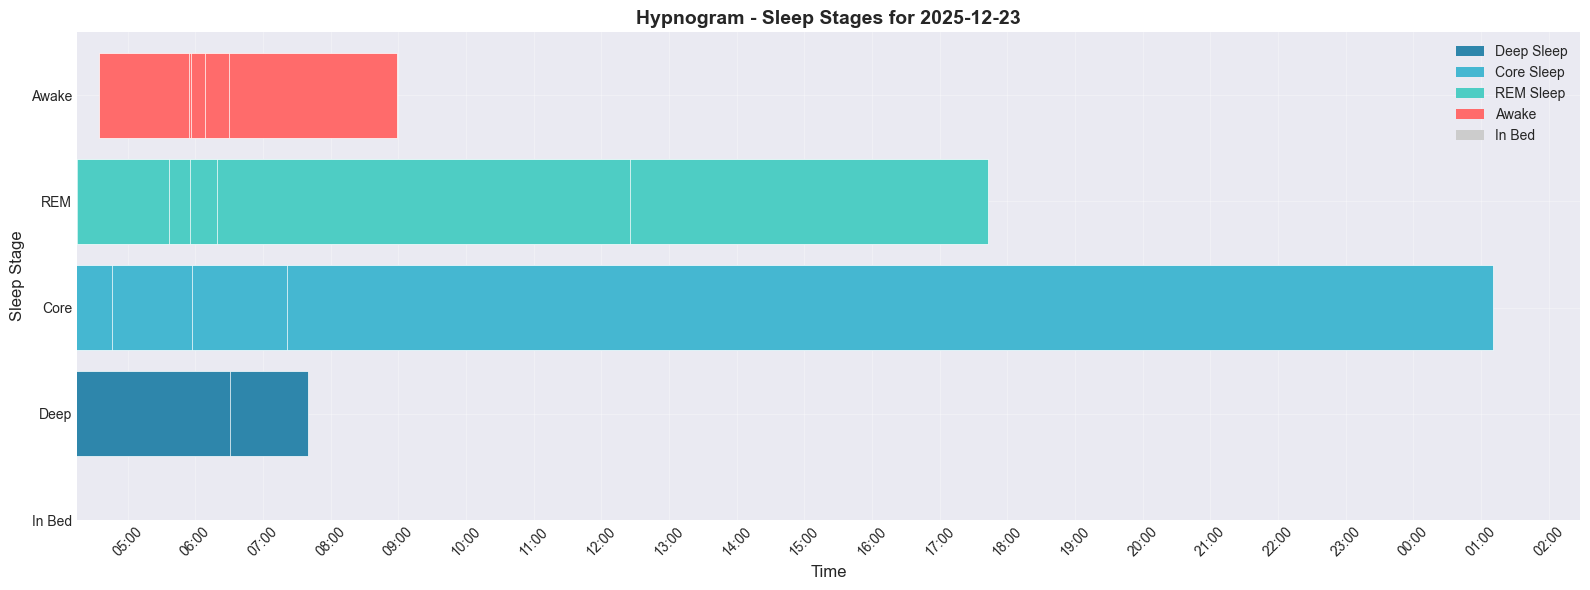

In [19]:
# 1. Hypnogram - Sleep stages over time for one night
def plot_hypnogram(sleep_data, night_date):
    """Plot a hypnogram (sleep stage visualization) for a specific night"""
    
    # Filter data for the specific night
    night_data = sleep_data[sleep_data['sleep_date'] == night_date].sort_values('startDate')
    
    if night_data.empty:
        print(f"No data for {night_date}")
        return
    
    # Define sleep stage levels for plotting
    stage_levels = {
        'HKCategoryValueSleepAnalysisAwake': 4,
        'HKCategoryValueSleepAnalysisAsleepREM': 3,
        'HKCategoryValueSleepAnalysisAsleepCore': 2,
        'HKCategoryValueSleepAnalysisAsleepDeep': 1,
        'HKCategoryValueSleepAnalysisInBed': 0
    }
    
    stage_colors = {
        'HKCategoryValueSleepAnalysisAwake': '#FF6B6B',
        'HKCategoryValueSleepAnalysisAsleepREM': '#4ECDC4',
        'HKCategoryValueSleepAnalysisAsleepCore': '#45B7D1',
        'HKCategoryValueSleepAnalysisAsleepDeep': '#2E86AB',
        'HKCategoryValueSleepAnalysisInBed': '#CCCCCC'
    }
    
    fig, ax = plt.subplots(figsize=(16, 6))
    
    # Plot each sleep stage as a horizontal bar
    for idx, row in night_data.iterrows():
        stage = row['value']
        level = stage_levels.get(stage, 0)
        color = stage_colors.get(stage, '#999999')
        
        start = row['startDate']
        end = row['endDate']
        duration = (end - start).total_seconds() / 3600  # hours
        
        ax.barh(level, duration, left=mdates.date2num(start), height=0.8, 
                color=color, edgecolor='white', linewidth=0.5)
    
    # Format x-axis as time
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    
    # Set y-axis labels
    ax.set_yticks([0, 1, 2, 3, 4])
    ax.set_yticklabels(['In Bed', 'Deep', 'Core', 'REM', 'Awake'])
    
    ax.set_xlabel('Time', fontsize=12)
    ax.set_ylabel('Sleep Stage', fontsize=12)
    ax.set_title(f'Hypnogram - Sleep Stages for {night_date}', fontsize=14, fontweight='bold')
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#2E86AB', label='Deep Sleep'),
        Patch(facecolor='#45B7D1', label='Core Sleep'),
        Patch(facecolor='#4ECDC4', label='REM Sleep'),
        Patch(facecolor='#FF6B6B', label='Awake'),
        Patch(facecolor='#CCCCCC', label='In Bed')
    ]
    ax.legend(handles=legend_elements, loc='upper right')
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(True, alpha=0.3)
    plt.show()

# Plot hypnogram for the most recent night
recent_date = sleep_stages_df['sleep_date'].max()
plot_hypnogram(sleep_stages_df, recent_date)

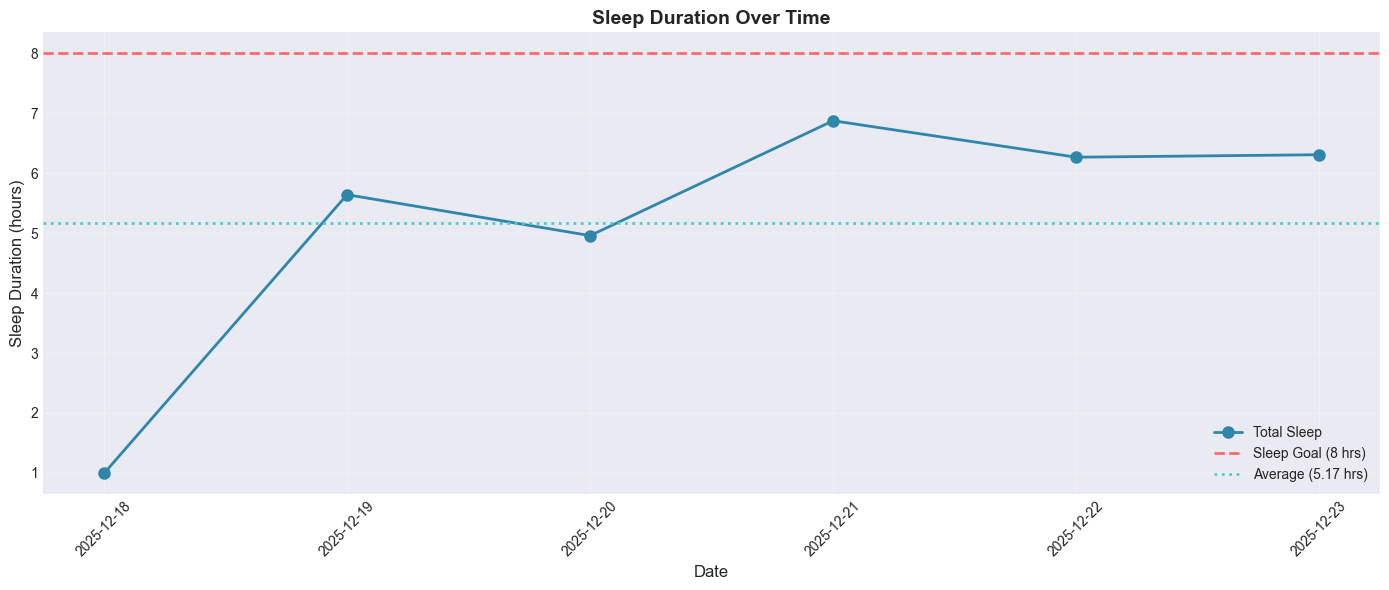

Average sleep: 5.17 hours
Sleep goal: 8 hours
Deficit: 2.83 hours per night


In [20]:
# 2. Sleep duration over time
fig, ax = plt.subplots(figsize=(14, 6))

# Use the nightly summary
nightly_summary['Date'] = pd.to_datetime(nightly_summary['Date'])
nightly_summary = nightly_summary.sort_values('Date')

# Plot total sleep duration
ax.plot(nightly_summary['Date'], nightly_summary['Total Sleep (hrs)'], 
        marker='o', linewidth=2, markersize=8, color='#2E86AB', label='Total Sleep')

# Add sleep goal line
ax.axhline(y=8, color='#FF6B6B', linestyle='--', linewidth=2, label='Sleep Goal (8 hrs)')

# Add average line
avg_sleep = nightly_summary['Total Sleep (hrs)'].mean()
ax.axhline(y=avg_sleep, color='#4ECDC4', linestyle=':', linewidth=2, 
           label=f'Average ({avg_sleep:.2f} hrs)')

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Sleep Duration (hours)', fontsize=12)
ax.set_title('Sleep Duration Over Time', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Format x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print(f"Average sleep: {avg_sleep:.2f} hours")
print(f"Sleep goal: 8 hours")
print(f"Deficit: {8 - avg_sleep:.2f} hours per night")

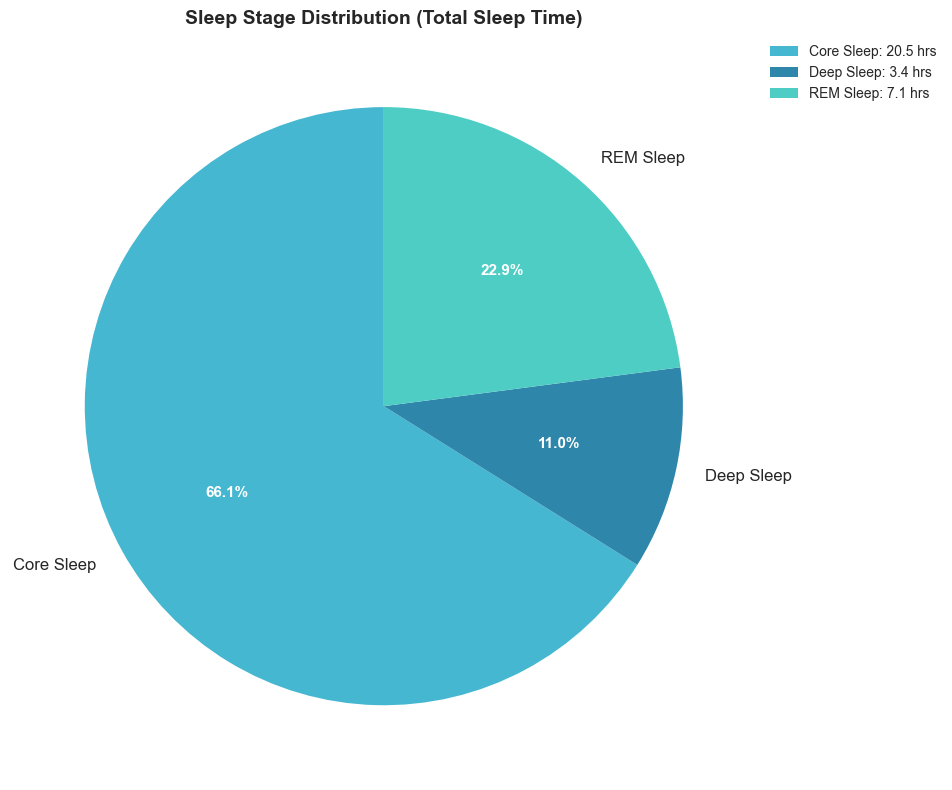


Sleep Stage Breakdown:
Core Sleep: 20.52 hours (66.1%)
Deep Sleep: 3.41 hours (11.0%)
REM Sleep: 7.12 hours (22.9%)


In [21]:
# 3. Sleep stage composition pie chart
stage_data = actual_sleep.groupby('value')['duration_hours'].sum()

# Clean up labels
stage_labels = {
    'HKCategoryValueSleepAnalysisAsleepCore': 'Core Sleep',
    'HKCategoryValueSleepAnalysisAsleepDeep': 'Deep Sleep',
    'HKCategoryValueSleepAnalysisAsleepREM': 'REM Sleep',
    'HKCategoryValueSleepAnalysisAwake': 'Awake'
}

cleaned_labels = [stage_labels.get(stage, stage) for stage in stage_data.index]
colors = ['#45B7D1', '#2E86AB', '#4ECDC4', '#FF6B6B']

fig, ax = plt.subplots(figsize=(10, 8))
wedges, texts, autotexts = ax.pie(stage_data.values, labels=cleaned_labels, autopct='%1.1f%%',
                                    colors=colors, startangle=90, textprops={'fontsize': 12})

# Make percentage text bold
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(11)

ax.set_title('Sleep Stage Distribution (Total Sleep Time)', fontsize=14, fontweight='bold')

# Add legend with hours
legend_labels = [f'{label}: {hours:.1f} hrs' for label, hours in zip(cleaned_labels, stage_data.values)]
ax.legend(legend_labels, loc='upper left', bbox_to_anchor=(1, 0, 0.5, 1))

plt.tight_layout()
plt.show()

print("\nSleep Stage Breakdown:")
for stage, hours in zip(cleaned_labels, stage_data.values):
    percentage = (hours / stage_data.sum()) * 100
    print(f"{stage}: {hours:.2f} hours ({percentage:.1f}%)")

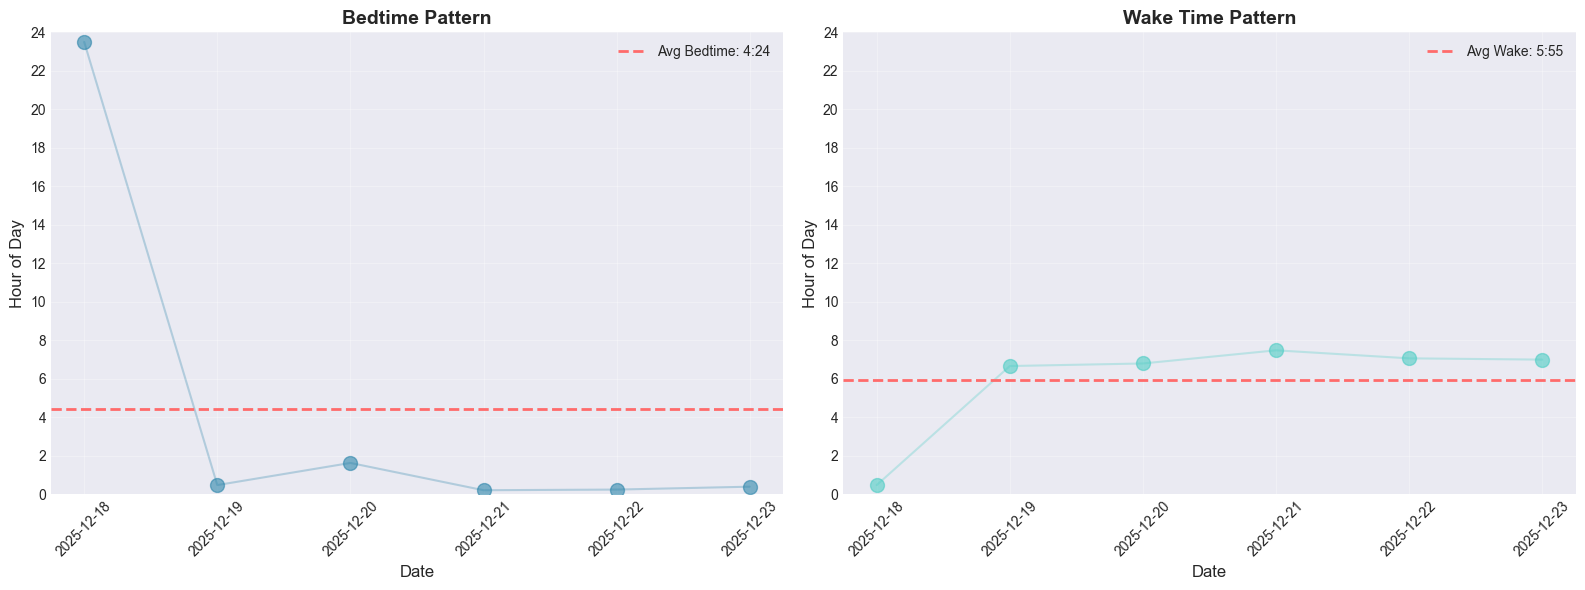

Average Bedtime: 4:24
Average Wake Time: 5:55


In [22]:
# 4. Sleep timing patterns - Bedtime and wake time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Prepare data - get bedtime and wake time for each night
night_times = []
for date in nightly_summary['Date']:
    night_data = sleep_stages_df[sleep_stages_df['sleep_date'] == date.date()].sort_values('startDate')
    if not night_data.empty:
        bedtime = night_data['startDate'].iloc[0]
        waketime = night_data['endDate'].iloc[-1]
        night_times.append({
            'date': date,
            'bedtime_hour': bedtime.hour + bedtime.minute/60,
            'waketime_hour': waketime.hour + waketime.minute/60
        })

night_times_df = pd.DataFrame(night_times)

# Plot 1: Bedtime consistency
ax1.scatter(night_times_df['date'], night_times_df['bedtime_hour'], 
            s=100, alpha=0.6, color='#2E86AB')
ax1.plot(night_times_df['date'], night_times_df['bedtime_hour'], 
         alpha=0.3, color='#2E86AB')

avg_bedtime = night_times_df['bedtime_hour'].mean()
ax1.axhline(y=avg_bedtime, color='#FF6B6B', linestyle='--', linewidth=2, 
            label=f'Avg Bedtime: {int(avg_bedtime)}:{int((avg_bedtime%1)*60):02d}')

ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Hour of Day', fontsize=12)
ax1.set_title('Bedtime Pattern', fontsize=14, fontweight='bold')
ax1.set_ylim(0, 24)
ax1.set_yticks(range(0, 25, 2))
ax1.grid(True, alpha=0.3)
ax1.legend()
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

# Plot 2: Wake time consistency
ax2.scatter(night_times_df['date'], night_times_df['waketime_hour'], 
            s=100, alpha=0.6, color='#4ECDC4')
ax2.plot(night_times_df['date'], night_times_df['waketime_hour'], 
         alpha=0.3, color='#4ECDC4')

avg_waketime = night_times_df['waketime_hour'].mean()
ax2.axhline(y=avg_waketime, color='#FF6B6B', linestyle='--', linewidth=2, 
            label=f'Avg Wake: {int(avg_waketime)}:{int((avg_waketime%1)*60):02d}')

ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Hour of Day', fontsize=12)
ax2.set_title('Wake Time Pattern', fontsize=14, fontweight='bold')
ax2.set_ylim(0, 24)
ax2.set_yticks(range(0, 25, 2))
ax2.grid(True, alpha=0.3)
ax2.legend()
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()

print(f"Average Bedtime: {int(avg_bedtime)}:{int((avg_bedtime%1)*60):02d}")
print(f"Average Wake Time: {int(avg_waketime)}:{int((avg_waketime%1)*60):02d}")

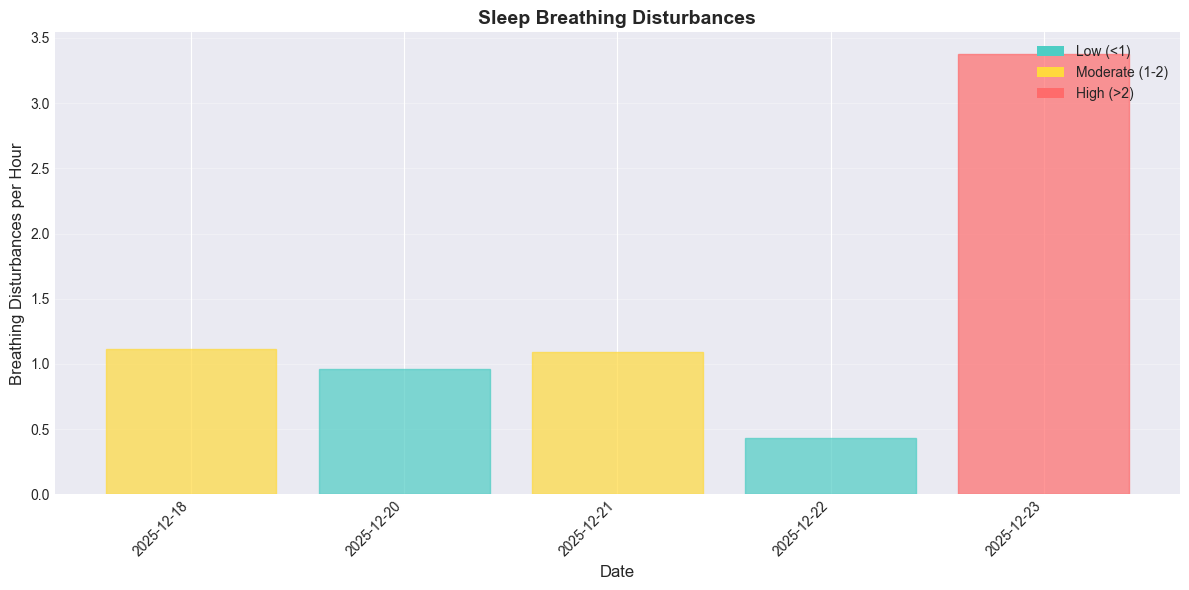


Breathing Disturbances Summary:
Average: 1.39 per hour
Range: 0.44 - 3.37 per hour


In [23]:
# 5. Breathing disturbances visualization
if not breathing_disturbances.empty:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    dates = breathing_disturbances['startDate'].dt.date
    values = breathing_disturbances['value'].astype(float)
    
    bars = ax.bar(range(len(dates)), values, color='#FF6B6B', alpha=0.7, edgecolor='black')
    
    # Color code by severity
    for i, (bar, val) in enumerate(zip(bars, values)):
        if val < 1:
            bar.set_color('#4ECDC4')  # Low - green
        elif val < 2:
            bar.set_color('#FFD93D')  # Moderate - yellow
        else:
            bar.set_color('#FF6B6B')  # High - red
    
    ax.set_xticks(range(len(dates)))
    ax.set_xticklabels([str(d) for d in dates], rotation=45, ha='right')
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Breathing Disturbances per Hour', fontsize=12)
    ax.set_title('Sleep Breathing Disturbances', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#4ECDC4', label='Low (<1)'),
        Patch(facecolor='#FFD93D', label='Moderate (1-2)'),
        Patch(facecolor='#FF6B6B', label='High (>2)')
    ]
    ax.legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nBreathing Disturbances Summary:")
    print(f"Average: {values.mean():.2f} per hour")
    print(f"Range: {values.min():.2f} - {values.max():.2f} per hour")
else:
    print("No breathing disturbance data available")

# Combined Activity and Sleep Timeline Visualization
24-hour view with dates on y-axis, showing both sleep stages and activity patterns.

In [24]:
# Prepare activity data - get workouts and high activity periods
# Filter for recent dates that match our sleep data
recent_dates = sorted(sleep_stages_df['sleep_date'].unique())

# Get heart rate data as proxy for activity
hr_data = df_records[df_records['type'] == 'HKQuantityTypeIdentifierHeartRate'].copy()
hr_data['startDate'] = pd.to_datetime(hr_data['startDate'])
hr_data['date'] = hr_data['startDate'].dt.date
hr_data['hour'] = hr_data['startDate'].dt.hour + hr_data['startDate'].dt.minute / 60
hr_data['value'] = pd.to_numeric(hr_data['value'], errors='coerce')

# Filter for recent dates
hr_data = hr_data[hr_data['date'].isin(recent_dates)]

print(f"Heart rate data points for visualization: {len(hr_data)}")
print(f"Date range: {hr_data['date'].min()} to {hr_data['date'].max()}")

Heart rate data points for visualization: 2233
Date range: 2025-12-18 to 2025-12-23


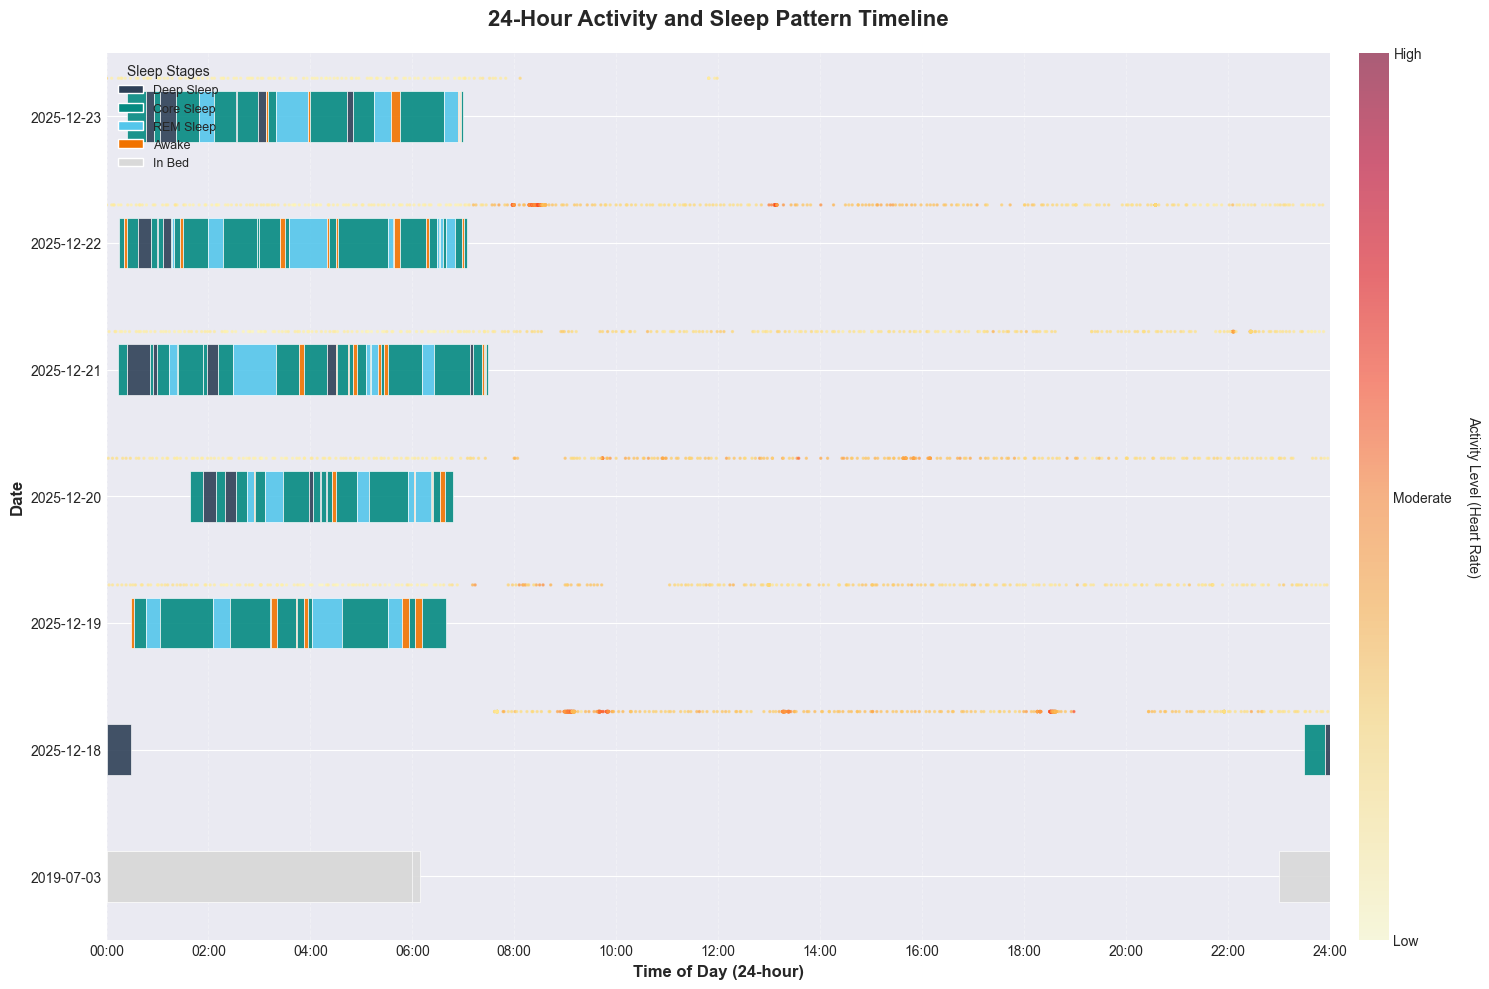


VISUALIZATION LEGEND:
• Horizontal bars = Sleep stages (positioned at y-center)
• Scatter points = Activity/Heart rate (positioned slightly above)
• Color intensity = Heart rate level (yellow to red)


In [25]:
# Create combined activity and sleep timeline plot
fig, ax = plt.subplots(figsize=(16, 10))

# Define colors for sleep stages
sleep_colors = {
    'HKCategoryValueSleepAnalysisAsleepDeep': '#2E4057',      # Dark blue
    'HKCategoryValueSleepAnalysisAsleepCore': '#048A81',      # Teal
    'HKCategoryValueSleepAnalysisAsleepREM': '#54C6EB',       # Light blue
    'HKCategoryValueSleepAnalysisAwake': '#F17300',           # Orange
    'HKCategoryValueSleepAnalysisInBed': '#D9D9D9'            # Light gray
}

# Sort dates for y-axis
dates_sorted = sorted(recent_dates)
date_to_y = {date: idx for idx, date in enumerate(dates_sorted)}

# 1. Plot sleep stages
for date in dates_sorted:
    day_sleep = sleep_stages_df[sleep_stages_df['sleep_date'] == date].sort_values('startDate')
    y_pos = date_to_y[date]
    
    for idx, row in day_sleep.iterrows():
        stage = row['value']
        color = sleep_colors.get(stage, '#999999')
        
        # Calculate time in hours from midnight
        start_hour = row['startDate'].hour + row['startDate'].minute / 60
        end_hour = row['endDate'].hour + row['endDate'].minute / 60
        
        # Handle cases crossing midnight
        if end_hour < start_hour:
            # Plot until midnight
            ax.barh(y_pos, 24 - start_hour, left=start_hour, height=0.4, 
                   color=color, alpha=0.9, edgecolor='white', linewidth=0.5)
            # Plot from midnight
            ax.barh(y_pos, end_hour, left=0, height=0.4, 
                   color=color, alpha=0.9, edgecolor='white', linewidth=0.5)
        else:
            duration = end_hour - start_hour
            ax.barh(y_pos, duration, left=start_hour, height=0.4, 
                   color=color, alpha=0.9, edgecolor='white', linewidth=0.5)

# 2. Plot activity (heart rate) as scatter points
for date in dates_sorted:
    day_hr = hr_data[hr_data['date'] == date]
    if not day_hr.empty:
        y_pos = date_to_y[date]
        
        # Normalize heart rate for color intensity (40-180 bpm range)
        hr_normalized = (day_hr['value'] - 40) / 140
        hr_normalized = hr_normalized.clip(0, 1)
        
        # Plot as small markers
        scatter = ax.scatter(day_hr['hour'], [y_pos + 0.3] * len(day_hr), 
                           c=hr_normalized, cmap='YlOrRd', 
                           s=2, alpha=0.6, vmin=0, vmax=1)

# Formatting
ax.set_xlim(0, 24)
ax.set_ylim(-0.5, len(dates_sorted) - 0.5)

# X-axis: time of day
ax.set_xticks(range(0, 25, 2))
ax.set_xticklabels([f'{h:02d}:00' for h in range(0, 25, 2)])
ax.set_xlabel('Time of Day (24-hour)', fontsize=12, fontweight='bold')

# Y-axis: dates
ax.set_yticks(range(len(dates_sorted)))
ax.set_yticklabels([str(date) for date in dates_sorted])
ax.set_ylabel('Date', fontsize=12, fontweight='bold')

# Title
ax.set_title('24-Hour Activity and Sleep Pattern Timeline', 
             fontsize=16, fontweight='bold', pad=20)

# Add colorbar for heart rate
cbar = plt.colorbar(scatter, ax=ax, pad=0.02, aspect=30)
cbar.set_label('Activity Level (Heart Rate)', rotation=270, labelpad=20, fontsize=10)
cbar.set_ticks([0, 0.5, 1])
cbar.set_ticklabels(['Low', 'Moderate', 'High'])

# Create legend for sleep stages
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2E4057', label='Deep Sleep', edgecolor='white'),
    Patch(facecolor='#048A81', label='Core Sleep', edgecolor='white'),
    Patch(facecolor='#54C6EB', label='REM Sleep', edgecolor='white'),
    Patch(facecolor='#F17300', label='Awake', edgecolor='white'),
    Patch(facecolor='#D9D9D9', label='In Bed', edgecolor='white')
]
ax.legend(handles=legend_elements, loc='upper left', fontsize=9, 
         title='Sleep Stages', title_fontsize=10)

# Add grid for time
ax.grid(True, axis='x', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print("VISUALIZATION LEGEND:")
print("• Horizontal bars = Sleep stages (positioned at y-center)")
print("• Scatter points = Activity/Heart rate (positioned slightly above)")
print("• Color intensity = Heart rate level (yellow to red)")
print(f"{'='*60}")

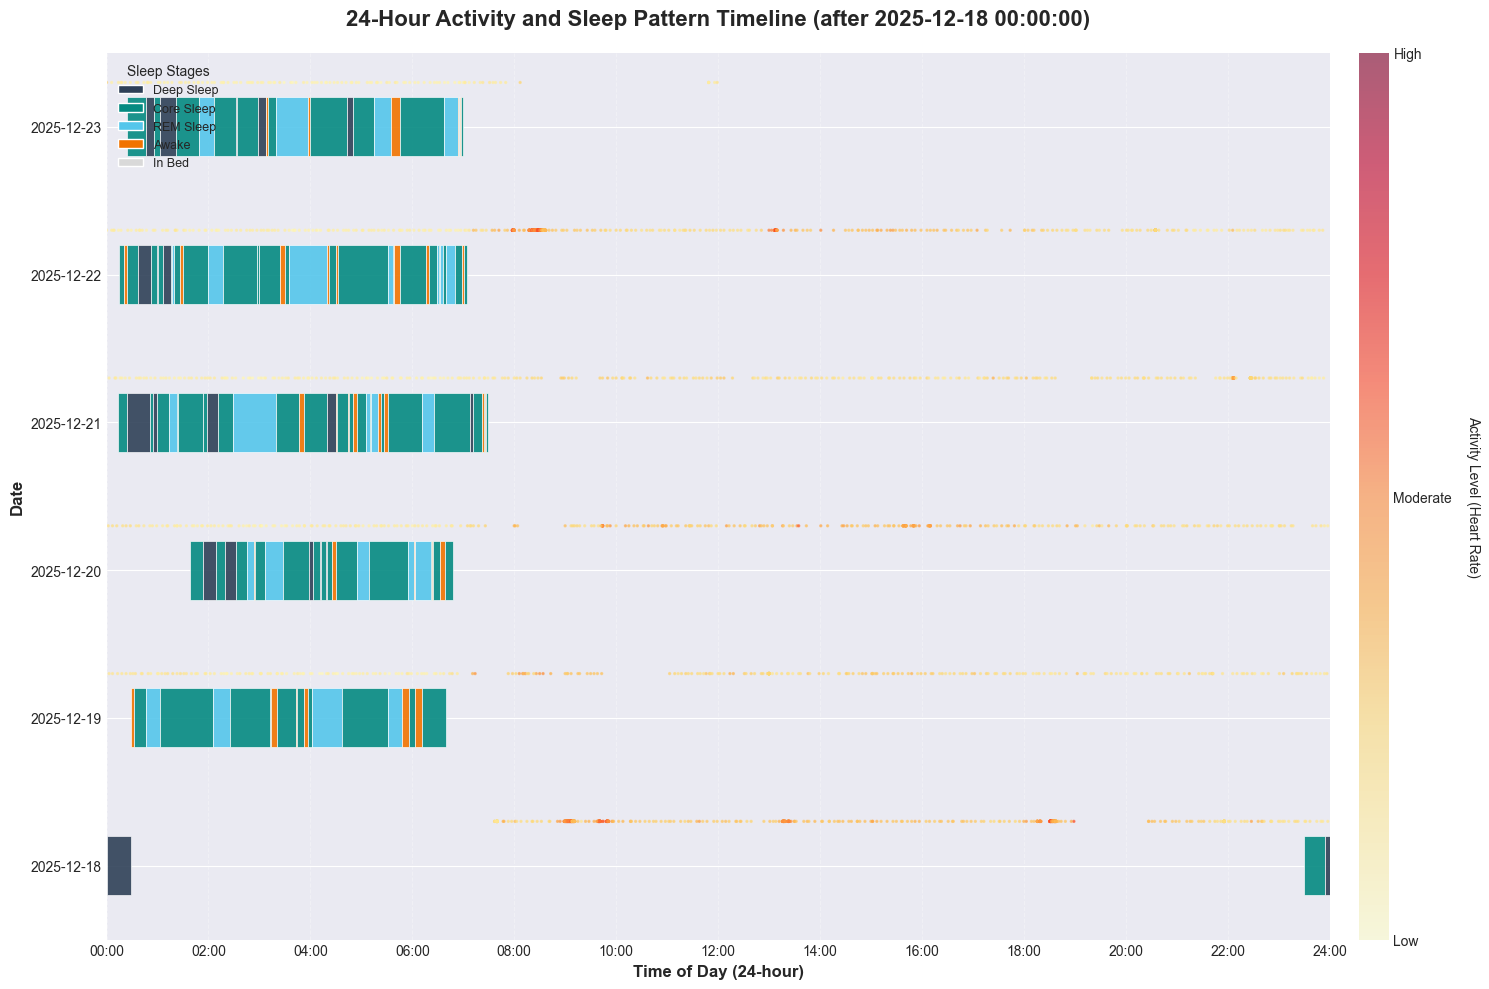


VISUALIZATION LEGEND:
• Horizontal bars = Sleep stages (positioned at y-center)
• Scatter points = Activity/Heart rate (positioned slightly above)
• Color intensity = Heart rate level (yellow to red)
Cutoff applied: 2025-12-18 00:00:00+01:00


In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# =========================
# 1) Filter everything AFTER cutoff (timezone-safe)
# =========================

cutoff_str = "2025-12-18 00:00:00"

# --- Sleep stages: ensure datetime + align cutoff tz to your data ---
sleep_stages_df_f = sleep_stages_df.copy()

sleep_stages_df_f["startDate"] = pd.to_datetime(sleep_stages_df_f["startDate"])
sleep_stages_df_f["endDate"]   = pd.to_datetime(sleep_stages_df_f["endDate"])

# Determine timezone from your data (prefer endDate, fallback to startDate)
tzinfo = None
try:
    tzinfo = sleep_stages_df_f["endDate"].dt.tz
except Exception:
    tzinfo = None
if tzinfo is None:
    try:
        tzinfo = sleep_stages_df_f["startDate"].dt.tz
    except Exception:
        tzinfo = None

# Build a cutoff timestamp that matches your data's tz-awareness
cutoff_dt = pd.Timestamp(cutoff_str)
if tzinfo is not None:
    # Make cutoff tz-aware in SAME tz as data
    cutoff_dt = cutoff_dt.tz_localize(tzinfo)
else:
    # Data is tz-naive; keep cutoff naive
    cutoff_dt = cutoff_dt.tz_localize(None)

# Keep only sleep segments that overlap cutoff or occur after it
sleep_stages_df_f = sleep_stages_df_f[sleep_stages_df_f["endDate"] >= cutoff_dt].copy()

# Clamp any segment that starts before cutoff so it doesn't plot pre-cutoff
sleep_stages_df_f.loc[sleep_stages_df_f["startDate"] < cutoff_dt, "startDate"] = cutoff_dt

# Recompute sleep_date based on (possibly clamped) startDate
# If your pipeline already has sleep_date, this ensures it matches the filtered view
sleep_stages_df_f["sleep_date"] = sleep_stages_df_f["startDate"].dt.date

# --- Heart rate: filter by cutoff too ---
hr_data_f = hr_data.copy()

# Make sure hr has a timestamp; adapt column name if yours differs
# Common names: "Timestamp", "startDate", "datetime", etc.
if "Timestamp" in hr_data_f.columns:
    hr_data_f["Timestamp"] = pd.to_datetime(hr_data_f["Timestamp"])
    hr_timecol = "Timestamp"
elif "startDate" in hr_data_f.columns:
    hr_data_f["startDate"] = pd.to_datetime(hr_data_f["startDate"])
    hr_timecol = "startDate"
elif "datetime" in hr_data_f.columns:
    hr_data_f["datetime"] = pd.to_datetime(hr_data_f["datetime"])
    hr_timecol = "datetime"
else:
    # If you only have 'date' + 'hour' already, we filter by date below as a fallback.
    hr_timecol = None

if hr_timecol is not None:
    # Align HR tz-awareness to cutoff (same rule: compare aware-aware or naive-naive)
    hr_tz = hr_data_f[hr_timecol].dt.tz
    cutoff_hr = pd.Timestamp(cutoff_str)
    if hr_tz is not None:
        cutoff_hr = cutoff_hr.tz_localize(hr_tz)
    else:
        cutoff_hr = cutoff_hr.tz_localize(None)

    hr_data_f = hr_data_f[hr_data_f[hr_timecol] >= cutoff_hr].copy()
    hr_data_f["date"] = hr_data_f[hr_timecol].dt.date
    hr_data_f["hour"] = hr_data_f[hr_timecol].dt.hour + hr_data_f[hr_timecol].dt.minute / 60.0
else:
    # Fallback if your hr_data has 'date' already (as datetime.date or string)
    hr_data_f["date"] = pd.to_datetime(hr_data_f["date"]).dt.date
    cutoff_date = pd.Timestamp(cutoff_str).date()
    hr_data_f = hr_data_f[hr_data_f["date"] >= cutoff_date].copy()

# Build the list of dates to plot AFTER cutoff (use union of both sources)
sleep_dates = set(sleep_stages_df_f["sleep_date"].unique())
hr_dates = set(hr_data_f["date"].unique()) if "date" in hr_data_f.columns else set()
recent_dates_f = sorted(list(sleep_dates.union(hr_dates)))

if len(recent_dates_f) == 0:
    print("No data found after cutoff:", cutoff_dt)
    raise SystemExit

# =========================
# 2) Plot: combined activity and sleep timeline
# =========================
fig, ax = plt.subplots(figsize=(16, 10))

sleep_colors = {
    "HKCategoryValueSleepAnalysisAsleepDeep": "#2E4057",
    "HKCategoryValueSleepAnalysisAsleepCore": "#048A81",
    "HKCategoryValueSleepAnalysisAsleepREM":  "#54C6EB",
    "HKCategoryValueSleepAnalysisAwake":      "#F17300",
    "HKCategoryValueSleepAnalysisInBed":      "#D9D9D9",
}

dates_sorted = recent_dates_f
date_to_y = {date: idx for idx, date in enumerate(dates_sorted)}

# 1) Plot sleep stages
for date in dates_sorted:
    day_sleep = sleep_stages_df_f[sleep_stages_df_f["sleep_date"] == date].sort_values("startDate")
    y_pos = date_to_y[date]

    for _, row in day_sleep.iterrows():
        stage = row["value"]
        color = sleep_colors.get(stage, "#999999")

        start_hour = row["startDate"].hour + row["startDate"].minute / 60
        end_hour   = row["endDate"].hour + row["endDate"].minute / 60

        # Handle cases crossing midnight
        if end_hour < start_hour:
            ax.barh(y_pos, 24 - start_hour, left=start_hour, height=0.4,
                    color=color, alpha=0.9, edgecolor="white", linewidth=0.5)
            ax.barh(y_pos, end_hour, left=0, height=0.4,
                    color=color, alpha=0.9, edgecolor="white", linewidth=0.5)
        else:
            duration = end_hour - start_hour
            ax.barh(y_pos, duration, left=start_hour, height=0.4,
                    color=color, alpha=0.9, edgecolor="white", linewidth=0.5)

# 2) Plot activity (heart rate) as scatter points
scatter = None
for date in dates_sorted:
    day_hr = hr_data_f[hr_data_f["date"] == date] if "date" in hr_data_f.columns else pd.DataFrame()
    if not day_hr.empty:
        y_pos = date_to_y[date]

        hr_normalized = (day_hr["value"] - 40) / 140
        hr_normalized = hr_normalized.clip(0, 1)

        scatter = ax.scatter(
            day_hr["hour"],
            [y_pos + 0.3] * len(day_hr),
            c=hr_normalized,
            cmap="YlOrRd",
            s=2,
            alpha=0.6,
            vmin=0,
            vmax=1,
        )

# Formatting
ax.set_xlim(0, 24)
ax.set_ylim(-0.5, len(dates_sorted) - 0.5)

ax.set_xticks(range(0, 25, 2))
ax.set_xticklabels([f"{h:02d}:00" for h in range(0, 25, 2)])
ax.set_xlabel("Time of Day (24-hour)", fontsize=12, fontweight="bold")

ax.set_yticks(range(len(dates_sorted)))
ax.set_yticklabels([str(date) for date in dates_sorted])
ax.set_ylabel("Date", fontsize=12, fontweight="bold")

ax.set_title(
    f"24-Hour Activity and Sleep Pattern Timeline (after {cutoff_str})",
    fontsize=16, fontweight="bold", pad=20
)

# Add colorbar for heart rate (only if scatter exists)
if scatter is not None:
    cbar = plt.colorbar(scatter, ax=ax, pad=0.02, aspect=30)
    cbar.set_label("Activity Level (Heart Rate)", rotation=270, labelpad=20, fontsize=10)
    cbar.set_ticks([0, 0.5, 1])
    cbar.set_ticklabels(["Low", "Moderate", "High"])

# Legend for sleep stages
legend_elements = [
    Patch(facecolor="#2E4057", label="Deep Sleep", edgecolor="white"),
    Patch(facecolor="#048A81", label="Core Sleep", edgecolor="white"),
    Patch(facecolor="#54C6EB", label="REM Sleep", edgecolor="white"),
    Patch(facecolor="#F17300", label="Awake", edgecolor="white"),
    Patch(facecolor="#D9D9D9", label="In Bed", edgecolor="white"),
]
ax.legend(handles=legend_elements, loc="upper left", fontsize=9,
          title="Sleep Stages", title_fontsize=10)

ax.grid(True, axis="x", alpha=0.3, linestyle="--")
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print("VISUALIZATION LEGEND:")
print("• Horizontal bars = Sleep stages (positioned at y-center)")
print("• Scatter points = Activity/Heart rate (positioned slightly above)")
print("• Color intensity = Heart rate level (yellow to red)")
print(f"Cutoff applied: {cutoff_dt}")
print(f"{'='*60}")


# Enhanced Activity Timeline with Multiple Metrics
Combining sleep stages with various activity measures: heart rate, steps, energy burned, and physical effort.

In [33]:
# Prepare multiple activity metrics
cutoff_str = "2025-12-19 00:00:00"
cutoff_dt = pd.Timestamp(cutoff_str)

# Get timezone from sleep data
tzinfo = sleep_stages_df['startDate'].dt.tz if hasattr(sleep_stages_df['startDate'].dt, 'tz') else None
if tzinfo is not None:
    cutoff_dt = cutoff_dt.tz_localize(tzinfo)

cutoff_date = cutoff_dt.date()
recent_dates_list = sorted([d for d in sleep_stages_df['sleep_date'].unique() if d >= cutoff_date])

# 1. Steps
steps_data = df_records[df_records['type'] == 'HKQuantityTypeIdentifierStepCount'].copy()
steps_data['startDate'] = pd.to_datetime(steps_data['startDate'])
steps_data = steps_data[steps_data['startDate'] >= cutoff_dt]
steps_data['date'] = steps_data['startDate'].dt.date
steps_data['hour'] = steps_data['startDate'].dt.hour + steps_data['startDate'].dt.minute / 60
steps_data['value'] = pd.to_numeric(steps_data['value'], errors='coerce')

# 2. Active Energy
energy_data = df_records[df_records['type'] == 'HKQuantityTypeIdentifierActiveEnergyBurned'].copy()
energy_data['startDate'] = pd.to_datetime(energy_data['startDate'])
energy_data = energy_data[energy_data['startDate'] >= cutoff_dt]
energy_data['date'] = energy_data['startDate'].dt.date
energy_data['hour'] = energy_data['startDate'].dt.hour + energy_data['startDate'].dt.minute / 60
energy_data['value'] = pd.to_numeric(energy_data['value'], errors='coerce')

# 3. Physical Effort
effort_data = df_records[df_records['type'] == 'HKQuantityTypeIdentifierPhysicalEffort'].copy()
effort_data['startDate'] = pd.to_datetime(effort_data['startDate'])
effort_data = effort_data[effort_data['startDate'] >= cutoff_dt]
effort_data['date'] = effort_data['startDate'].dt.date
effort_data['hour'] = effort_data['startDate'].dt.hour + effort_data['startDate'].dt.minute / 60
effort_data['value'] = pd.to_numeric(effort_data['value'], errors='coerce')

# 4. Heart Rate (already prepared)
hr_data_filtered = hr_data[hr_data['startDate'] >= cutoff_dt].copy()

print("Activity Data Summary:")
print(f"  Steps records: {len(steps_data)}")
print(f"  Energy burned records: {len(energy_data)}")
print(f"  Physical effort records: {len(effort_data)}")
print(f"  Heart rate records: {len(hr_data_filtered)}")
print(f"\nDate range: {min(recent_dates_list)} to {max(recent_dates_list)}")

Activity Data Summary:
  Steps records: 405
  Energy burned records: 963
  Physical effort records: 1825
  Heart rate records: 1636

Date range: 2025-12-19 to 2025-12-23


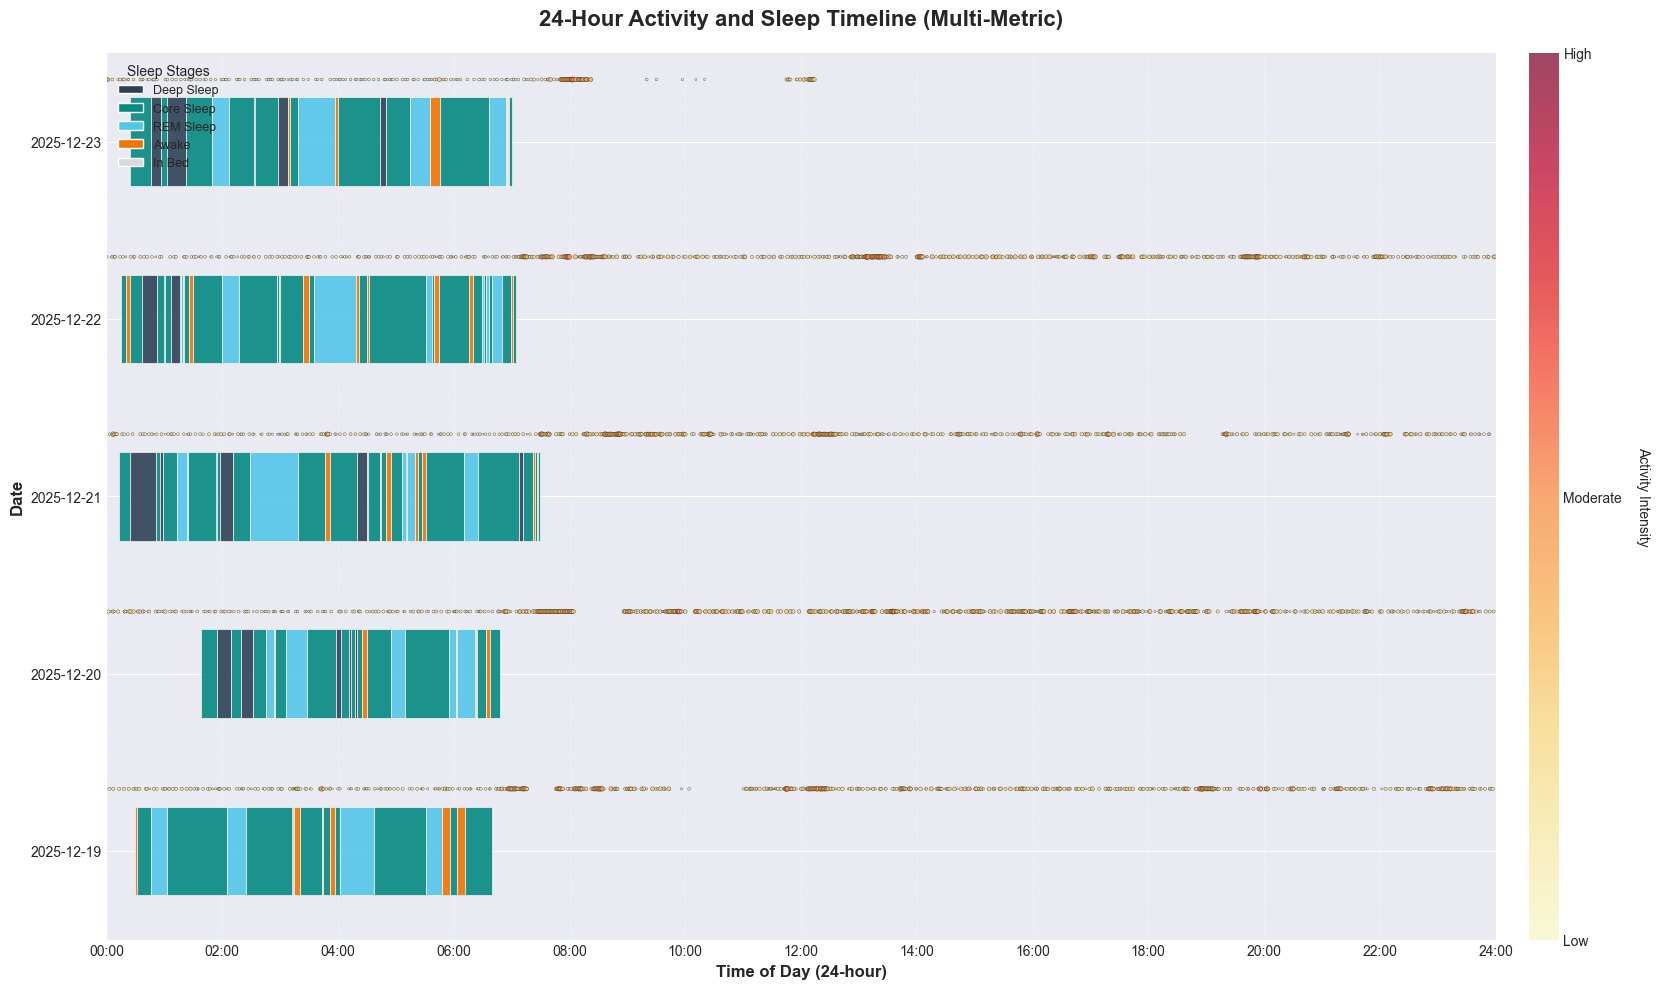


VISUALIZATION LEGEND:
• Horizontal bars = Sleep stages
• Scatter points = Combined activity (heart rate + steps + energy + effort)
• Point size = Activity intensity
• Color intensity = Activity level (yellow to red)

Metrics combined:
  - Heart Rate (40-180 bpm)
  - Steps (per measurement)
  - Active Energy Burned (kcal)
  - Physical Effort (0-10 scale)


In [34]:
# Create enhanced combined visualization with multiple activity metrics
fig, ax = plt.subplots(figsize=(18, 10))

sleep_colors = {
    "HKCategoryValueSleepAnalysisAsleepDeep": "#2E4057",
    "HKCategoryValueSleepAnalysisAsleepCore": "#048A81",
    "HKCategoryValueSleepAnalysisAsleepREM":  "#54C6EB",
    "HKCategoryValueSleepAnalysisAwake":      "#F17300",
    "HKCategoryValueSleepAnalysisInBed":      "#D9D9D9",
}

dates_sorted = recent_dates_list
date_to_y = {date: idx for idx, date in enumerate(dates_sorted)}

# Filter sleep data
sleep_filtered = sleep_stages_df[sleep_stages_df['sleep_date'].isin(recent_dates_list)]

# 1) Plot sleep stages as horizontal bars
for date in dates_sorted:
    day_sleep = sleep_filtered[sleep_filtered['sleep_date'] == date].sort_values('startDate')
    y_pos = date_to_y[date]

    for _, row in day_sleep.iterrows():
        stage = row['value']
        color = sleep_colors.get(stage, "#999999")

        start_hour = row['startDate'].hour + row['startDate'].minute / 60
        end_hour = row['endDate'].hour + row['endDate'].minute / 60

        if end_hour < start_hour:
            ax.barh(y_pos, 24 - start_hour, left=start_hour, height=0.5,
                    color=color, alpha=0.9, edgecolor='white', linewidth=0.5)
            ax.barh(y_pos, end_hour, left=0, height=0.5,
                    color=color, alpha=0.9, edgecolor='white', linewidth=0.5)
        else:
            duration = end_hour - start_hour
            ax.barh(y_pos, duration, left=start_hour, height=0.5,
                    color=color, alpha=0.9, edgecolor='white', linewidth=0.5)

# 2) Create composite activity score for visualization
activity_scores = []

for date in dates_sorted:
    y_pos = date_to_y[date]
    
    # Get data for this date
    day_steps = steps_data[steps_data['date'] == date]
    day_energy = energy_data[energy_data['date'] == date]
    day_effort = effort_data[effort_data['date'] == date]
    day_hr = hr_data_filtered[hr_data_filtered['date'] == date]
    
    # Combine all activity data points
    all_hours = []
    all_scores = []
    
    # Steps contribution (normalize by max steps per hour, e.g., 2000)
    if not day_steps.empty:
        for _, row in day_steps.iterrows():
            all_hours.append(row['hour'])
            score = min(row['value'] / 2000, 1.0)  # Normalize steps
            all_scores.append({'hour': row['hour'], 'score': score, 'type': 'steps'})
    
    # Energy contribution (normalize by 100 kcal)
    if not day_energy.empty:
        for _, row in day_energy.iterrows():
            all_hours.append(row['hour'])
            score = min(row['value'] / 100, 1.0)  # Normalize energy
            all_scores.append({'hour': row['hour'], 'score': score, 'type': 'energy'})
    
    # Physical effort contribution (already 0-10 scale, normalize to 0-1)
    if not day_effort.empty:
        for _, row in day_effort.iterrows():
            all_hours.append(row['hour'])
            score = min(row['value'] / 10, 1.0)  # Normalize effort
            all_scores.append({'hour': row['hour'], 'score': score, 'type': 'effort'})
    
    # Heart rate contribution (normalize 40-180 bpm)
    if not day_hr.empty:
        for _, row in day_hr.iterrows():
            all_hours.append(row['hour'])
            score = min(max((row['value'] - 40) / 140, 0), 1.0)  # Normalize HR
            all_scores.append({'hour': row['hour'], 'score': score, 'type': 'hr'})
    
    # Aggregate scores by hour (average if multiple measures)
    if all_scores:
        scores_df = pd.DataFrame(all_scores)
        hourly_avg = scores_df.groupby('hour')['score'].mean()
        
        # Plot as scatter with size and color representing activity level
        hours = hourly_avg.index.values
        scores = hourly_avg.values
        
        # Size based on intensity
        sizes = scores * 20 + 2
        
        scatter = ax.scatter(hours, [y_pos + 0.35] * len(hours),
                           c=scores, cmap='YlOrRd',
                           s=sizes, alpha=0.7, vmin=0, vmax=1,
                           edgecolors='black', linewidth=0.3)

# Formatting
ax.set_xlim(0, 24)
ax.set_ylim(-0.5, len(dates_sorted) - 0.5)

ax.set_xticks(range(0, 25, 2))
ax.set_xticklabels([f"{h:02d}:00" for h in range(0, 25, 2)])
ax.set_xlabel("Time of Day (24-hour)", fontsize=12, fontweight="bold")

ax.set_yticks(range(len(dates_sorted)))
ax.set_yticklabels([str(date) for date in dates_sorted])
ax.set_ylabel("Date", fontsize=12, fontweight="bold")

ax.set_title(
    "24-Hour Activity and Sleep Timeline (Multi-Metric)",
    fontsize=16, fontweight="bold", pad=20
)

# Add colorbar
if 'scatter' in locals():
    cbar = plt.colorbar(scatter, ax=ax, pad=0.02, aspect=30)
    cbar.set_label("Activity Intensity", rotation=270, labelpad=20, fontsize=10)
    cbar.set_ticks([0, 0.5, 1])
    cbar.set_ticklabels(["Low", "Moderate", "High"])

# Legend for sleep stages
legend_elements = [
    Patch(facecolor="#2E4057", label="Deep Sleep", edgecolor="white"),
    Patch(facecolor="#048A81", label="Core Sleep", edgecolor="white"),
    Patch(facecolor="#54C6EB", label="REM Sleep", edgecolor="white"),
    Patch(facecolor="#F17300", label="Awake", edgecolor="white"),
    Patch(facecolor="#D9D9D9", label="In Bed", edgecolor="white"),
]
ax.legend(handles=legend_elements, loc="upper left", fontsize=9,
         title="Sleep Stages", title_fontsize=10)

ax.grid(True, axis="x", alpha=0.3, linestyle="--")
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

print(f"\n{'='*70}")
print("VISUALIZATION LEGEND:")
print("• Horizontal bars = Sleep stages")
print("• Scatter points = Combined activity (heart rate + steps + energy + effort)")
print("• Point size = Activity intensity")
print("• Color intensity = Activity level (yellow to red)")
print(f"\nMetrics combined:")
print("  - Heart Rate (40-180 bpm)")
print("  - Steps (per measurement)")
print("  - Active Energy Burned (kcal)")
print("  - Physical Effort (0-10 scale)")
print(f"{'='*70}")

# Separated Activity Metrics Visualization
Each activity metric displayed on its own row for clear comparison.

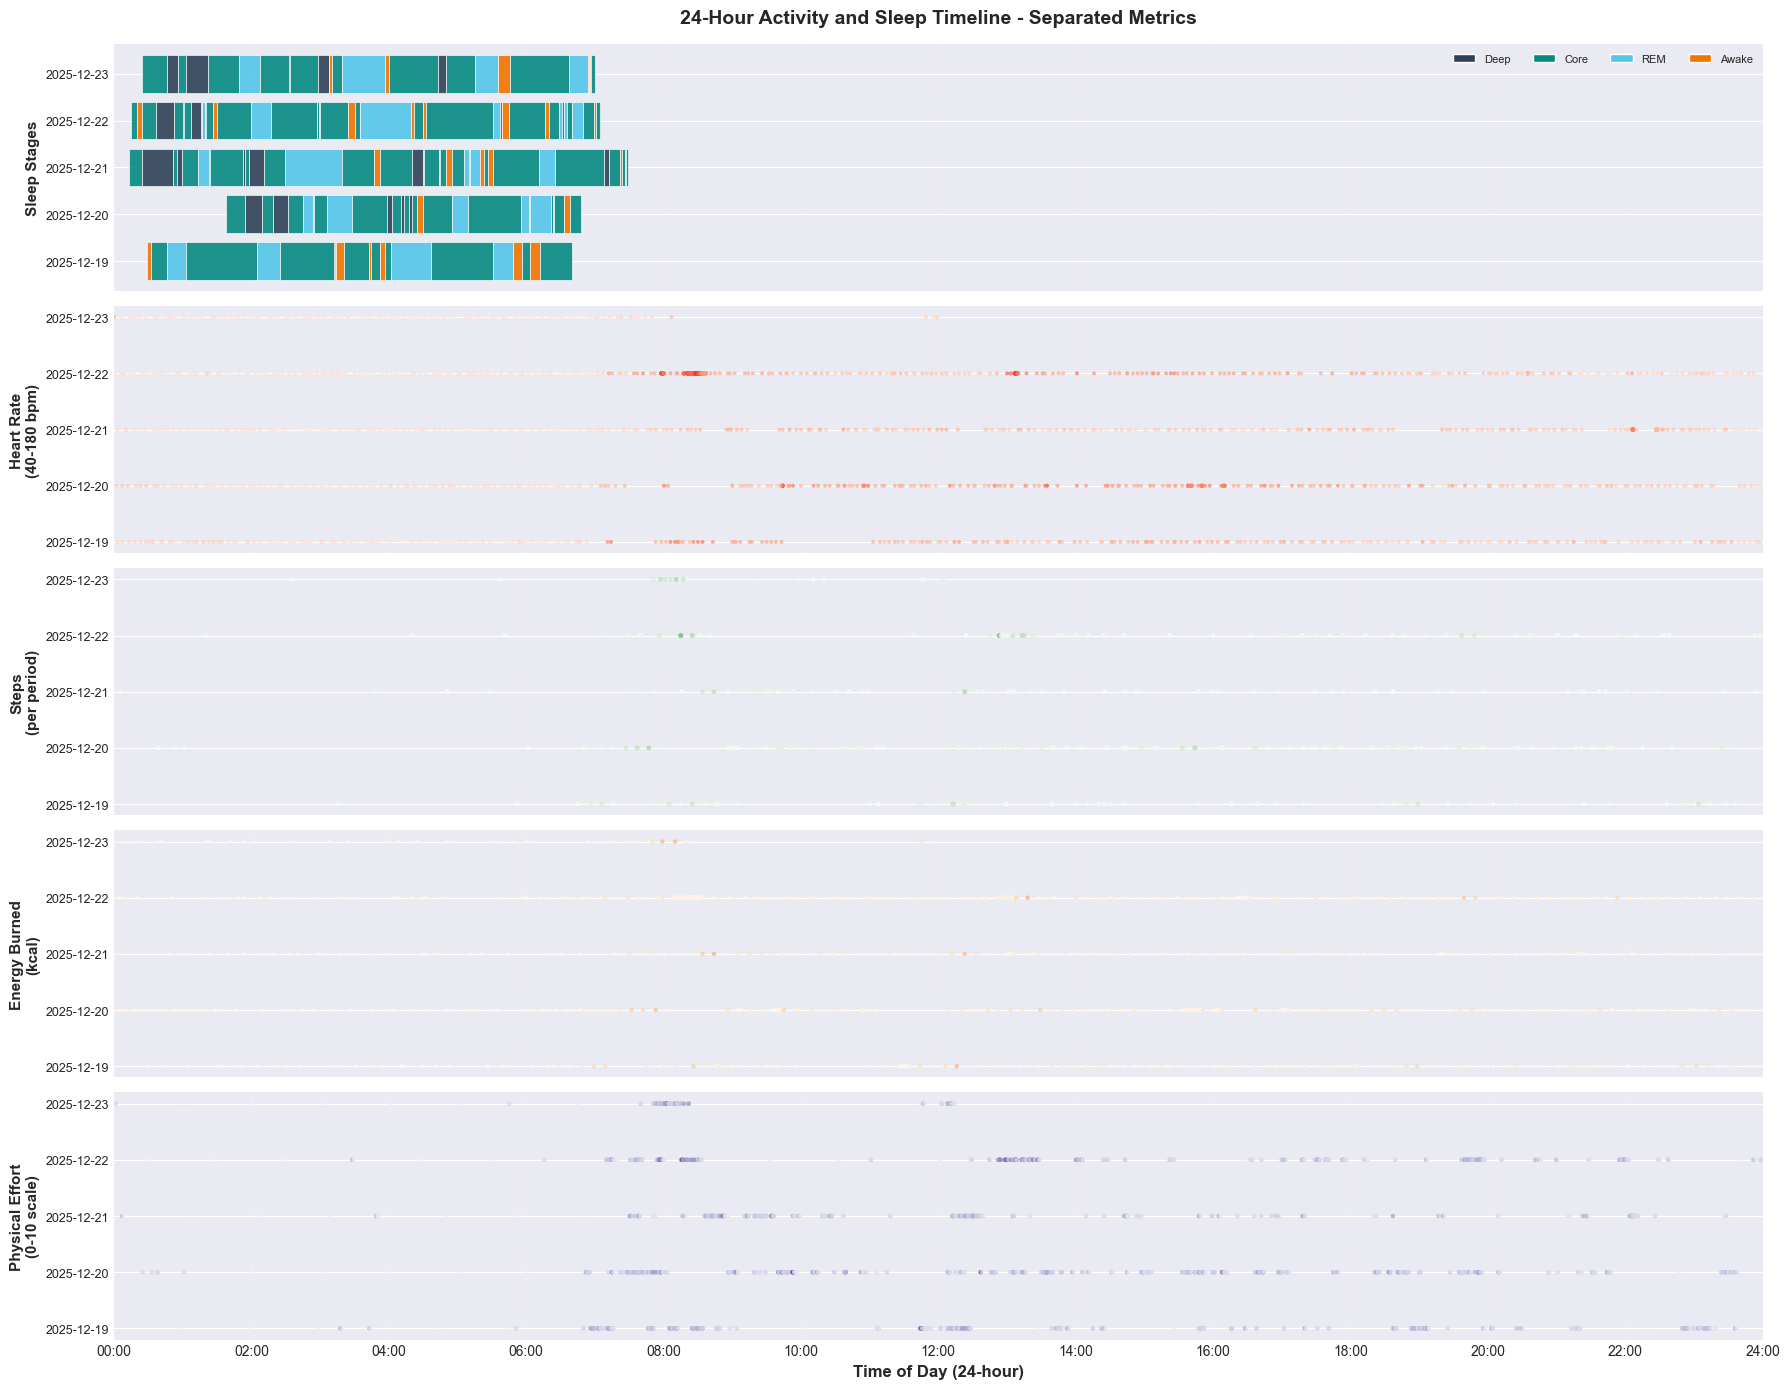


METRIC DEFINITIONS:

1. SLEEP STAGES:
   • Deep Sleep: Restorative slow-wave sleep
   • Core Sleep: Light NREM sleep (stages 1-2)
   • REM Sleep: Rapid Eye Movement, dreaming phase
   • Awake: Brief wake periods during sleep

2. HEART RATE (bpm):
   • Measured continuously by Apple Watch
   • Range: 40-180 bpm (normalized)
   • Higher values = more intense activity

3. STEPS (count per measurement):
   • Number of steps detected per time period
   • Normalized by 2000 steps as 'high' threshold
   • Color intensity shows step count

4. ACTIVE ENERGY BURNED (kcal):
   • Calories burned through activity (excludes resting)
   • Normalized by 100 kcal per period
   • Accumulated throughout activities

5. PHYSICAL EFFORT (0-10 scale):
   • Subjective measure of exertion
   • 0 = Minimal effort, 10 = Maximum effort
   • Rated by watch based on HR, movement, etc.


In [35]:
# Create visualization with separate rows for each metric
fig, axes = plt.subplots(5, 1, figsize=(18, 14), sharex=True)

sleep_colors = {
    "HKCategoryValueSleepAnalysisAsleepDeep": "#2E4057",
    "HKCategoryValueSleepAnalysisAsleepCore": "#048A81",
    "HKCategoryValueSleepAnalysisAsleepREM":  "#54C6EB",
    "HKCategoryValueSleepAnalysisAwake":      "#F17300",
    "HKCategoryValueSleepAnalysisInBed":      "#D9D9D9",
}

dates_sorted = recent_dates_list
date_to_y = {date: idx for idx, date in enumerate(dates_sorted)}
sleep_filtered = sleep_stages_df[sleep_stages_df['sleep_date'].isin(recent_dates_list)]

# === ROW 1: SLEEP STAGES ===
ax0 = axes[0]
for date in dates_sorted:
    day_sleep = sleep_filtered[sleep_filtered['sleep_date'] == date].sort_values('startDate')
    y_pos = date_to_y[date]

    for _, row in day_sleep.iterrows():
        stage = row['value']
        color = sleep_colors.get(stage, "#999999")
        start_hour = row['startDate'].hour + row['startDate'].minute / 60
        end_hour = row['endDate'].hour + row['endDate'].minute / 60

        if end_hour < start_hour:
            ax0.barh(y_pos, 24 - start_hour, left=start_hour, height=0.8,
                    color=color, alpha=0.9, edgecolor='white', linewidth=0.5)
            ax0.barh(y_pos, end_hour, left=0, height=0.8,
                    color=color, alpha=0.9, edgecolor='white', linewidth=0.5)
        else:
            duration = end_hour - start_hour
            ax0.barh(y_pos, duration, left=start_hour, height=0.8,
                    color=color, alpha=0.9, edgecolor='white', linewidth=0.5)

ax0.set_ylabel("Sleep Stages", fontsize=11, fontweight='bold')
ax0.set_yticks(range(len(dates_sorted)))
ax0.set_yticklabels([str(date) for date in dates_sorted], fontsize=9)
ax0.set_xlim(0, 24)
ax0.grid(True, axis='x', alpha=0.2, linestyle='--')
ax0.set_title("24-Hour Activity and Sleep Timeline - Separated Metrics", 
              fontsize=14, fontweight='bold', pad=15)

# Add sleep legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor="#2E4057", label="Deep", edgecolor="white"),
    Patch(facecolor="#048A81", label="Core", edgecolor="white"),
    Patch(facecolor="#54C6EB", label="REM", edgecolor="white"),
    Patch(facecolor="#F17300", label="Awake", edgecolor="white"),
]
ax0.legend(handles=legend_elements, loc="upper right", fontsize=8, ncol=4)

# === ROW 2: HEART RATE (bpm) ===
ax1 = axes[1]
for date in dates_sorted:
    day_hr = hr_data_filtered[hr_data_filtered['date'] == date]
    if not day_hr.empty:
        y_pos = date_to_y[date]
        hr_values = day_hr['value'].values
        hr_norm = np.clip((hr_values - 40) / 140, 0, 1)
        
        scatter1 = ax1.scatter(day_hr['hour'], [y_pos] * len(day_hr),
                              c=hr_norm, cmap='Reds', s=8, alpha=0.7,
                              vmin=0, vmax=1, edgecolors='none')

ax1.set_ylabel("Heart Rate\n(40-180 bpm)", fontsize=11, fontweight='bold')
ax1.set_yticks(range(len(dates_sorted)))
ax1.set_yticklabels([str(date) for date in dates_sorted], fontsize=9)
ax1.set_xlim(0, 24)
ax1.grid(True, axis='x', alpha=0.2, linestyle='--')

# === ROW 3: STEPS (count per measurement) ===
ax2 = axes[2]
for date in dates_sorted:
    day_steps = steps_data[steps_data['date'] == date]
    if not day_steps.empty:
        y_pos = date_to_y[date]
        step_values = day_steps['value'].values
        step_norm = np.clip(step_values / 2000, 0, 1)  # Normalize by 2000 steps
        
        scatter2 = ax2.scatter(day_steps['hour'], [y_pos] * len(day_steps),
                              c=step_norm, cmap='Greens', s=12, alpha=0.7,
                              vmin=0, vmax=1, edgecolors='none')

ax2.set_ylabel("Steps\n(per period)", fontsize=11, fontweight='bold')
ax2.set_yticks(range(len(dates_sorted)))
ax2.set_yticklabels([str(date) for date in dates_sorted], fontsize=9)
ax2.set_xlim(0, 24)
ax2.grid(True, axis='x', alpha=0.2, linestyle='--')

# === ROW 4: ACTIVE ENERGY (kcal) ===
ax3 = axes[3]
for date in dates_sorted:
    day_energy = energy_data[energy_data['date'] == date]
    if not day_energy.empty:
        y_pos = date_to_y[date]
        energy_values = day_energy['value'].values
        energy_norm = np.clip(energy_values / 100, 0, 1)  # Normalize by 100 kcal
        
        scatter3 = ax3.scatter(day_energy['hour'], [y_pos] * len(day_energy),
                              c=energy_norm, cmap='Oranges', s=10, alpha=0.7,
                              vmin=0, vmax=1, edgecolors='none')

ax3.set_ylabel("Energy Burned\n(kcal)", fontsize=11, fontweight='bold')
ax3.set_yticks(range(len(dates_sorted)))
ax3.set_yticklabels([str(date) for date in dates_sorted], fontsize=9)
ax3.set_xlim(0, 24)
ax3.grid(True, axis='x', alpha=0.2, linestyle='--')

# === ROW 5: PHYSICAL EFFORT (0-10 scale) ===
ax4 = axes[4]
for date in dates_sorted:
    day_effort = effort_data[effort_data['date'] == date]
    if not day_effort.empty:
        y_pos = date_to_y[date]
        effort_values = day_effort['value'].values
        effort_norm = np.clip(effort_values / 10, 0, 1)  # Normalize by 10
        
        scatter4 = ax4.scatter(day_effort['hour'], [y_pos] * len(day_effort),
                              c=effort_norm, cmap='Purples', s=10, alpha=0.7,
                              vmin=0, vmax=1, edgecolors='none')

ax4.set_ylabel("Physical Effort\n(0-10 scale)", fontsize=11, fontweight='bold')
ax4.set_yticks(range(len(dates_sorted)))
ax4.set_yticklabels([str(date) for date in dates_sorted], fontsize=9)
ax4.set_xlim(0, 24)
ax4.set_xlabel("Time of Day (24-hour)", fontsize=12, fontweight='bold')
ax4.set_xticks(range(0, 25, 2))
ax4.set_xticklabels([f"{h:02d}:00" for h in range(0, 25, 2)])
ax4.grid(True, axis='x', alpha=0.2, linestyle='--')

plt.tight_layout()
plt.show()

print(f"\n{'='*70}")
print("METRIC DEFINITIONS:")
print(f"{'='*70}")
print("\n1. SLEEP STAGES:")
print("   • Deep Sleep: Restorative slow-wave sleep")
print("   • Core Sleep: Light NREM sleep (stages 1-2)")
print("   • REM Sleep: Rapid Eye Movement, dreaming phase")
print("   • Awake: Brief wake periods during sleep")
print("\n2. HEART RATE (bpm):")
print("   • Measured continuously by Apple Watch")
print("   • Range: 40-180 bpm (normalized)")
print("   • Higher values = more intense activity")
print("\n3. STEPS (count per measurement):")
print("   • Number of steps detected per time period")
print("   • Normalized by 2000 steps as 'high' threshold")
print("   • Color intensity shows step count")
print("\n4. ACTIVE ENERGY BURNED (kcal):")
print("   • Calories burned through activity (excludes resting)")
print("   • Normalized by 100 kcal per period")
print("   • Accumulated throughout activities")
print("\n5. PHYSICAL EFFORT (0-10 scale):")
print("   • Subjective measure of exertion")
print("   • 0 = Minimal effort, 10 = Maximum effort")
print("   • Rated by watch based on HR, movement, etc.")
print(f"{'='*70}")

/var/folders/j5/c5vt47v9695609y1ssl7zjdr0000gn/T/ipykernel_11477/1240581910.py:187: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


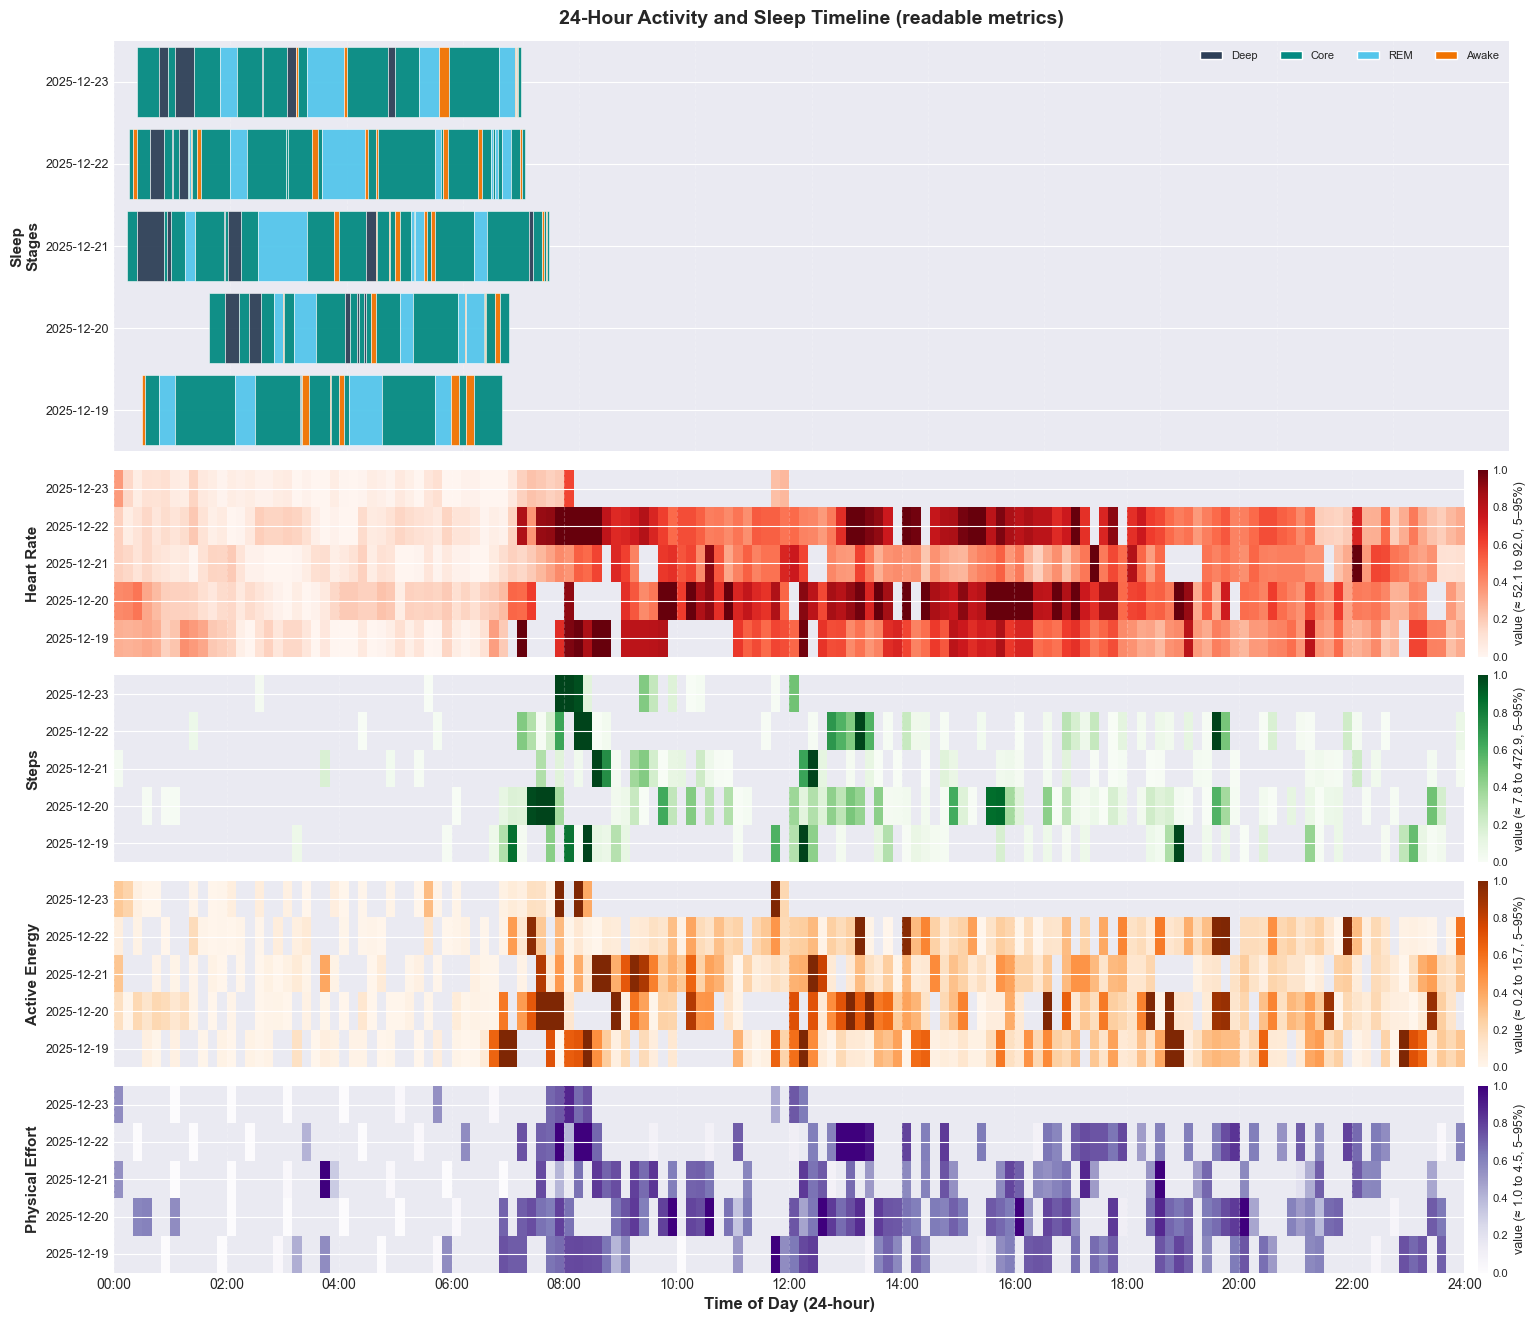

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# ---------- helpers ----------
def to_timebin(df, hour_col="hour", value_col="value", bin_minutes=10):
    """
    Expects df with columns:
      - hour_col: float in [0,24)
      - value_col: numeric
    Returns: (bin_centers_hours, binned_values) aligned to regular bins across 24h.
    """
    bins_per_day = int(24 * 60 / bin_minutes)
    edges = np.linspace(0, 24, bins_per_day + 1)
    centers = (edges[:-1] + edges[1:]) / 2

    # bin index
    x = df[hour_col].to_numpy()
    v = df[value_col].to_numpy()
    idx = np.digitize(x, edges) - 1
    idx = np.clip(idx, 0, bins_per_day - 1)

    out = np.full(bins_per_day, np.nan, dtype=float)

    # average if multiple samples per bin
    for i in range(bins_per_day):
        m = idx == i
        if np.any(m):
            out[i] = np.nanmean(v[m])
    return centers, out

def robust_norm(arr, low=5, high=95):
    """Return normalized array in [0,1] using robust percentiles (ignores NaNs)."""
    finite = arr[np.isfinite(arr)]
    if finite.size == 0:
        return arr, 0, 1
    vmin = np.percentile(finite, low)
    vmax = np.percentile(finite, high)
    if np.isclose(vmin, vmax):
        vmax = vmin + 1e-6
    normed = (arr - vmin) / (vmax - vmin)
    return np.clip(normed, 0, 1), vmin, vmax

def build_day_matrix(df, dates_sorted, date_col="date", hour_col="hour", value_col="value", bin_minutes=10):
    """Matrix shape: (n_days, n_bins) with binned mean values."""
    mats = []
    centers = None
    for d in dates_sorted:
        day = df[df[date_col] == d]
        if day.empty:
            # create empty row once we know bins
            if centers is None:
                centers = np.linspace(0, 24, int(24*60/bin_minutes), endpoint=False) + (bin_minutes/60)/2
            mats.append(np.full(len(centers), np.nan))
        else:
            centers, row = to_timebin(day, hour_col=hour_col, value_col=value_col, bin_minutes=bin_minutes)
            mats.append(row)
    return centers, np.vstack(mats)

# ---------- your existing inputs ----------
dates_sorted = recent_dates_list
date_to_y = {date: idx for idx, date in enumerate(dates_sorted)}

sleep_colors = {
    "HKCategoryValueSleepAnalysisAsleepDeep": "#2E4057",
    "HKCategoryValueSleepAnalysisAsleepCore": "#048A81",
    "HKCategoryValueSleepAnalysisAsleepREM": "#54C6EB",
    "HKCategoryValueSleepAnalysisAwake": "#F17300",
    "HKCategoryValueSleepAnalysisInBed": "#D9D9D9",
}

sleep_filtered = sleep_stages_df[sleep_stages_df['sleep_date'].isin(recent_dates_list)]

# ---------- figure layout (give sleep more height) ----------
fig, axes = plt.subplots(
    5, 1, figsize=(18, 16), sharex=True,
    gridspec_kw={"height_ratios": [2.2, 1, 1, 1, 1], "hspace": 0.08}
)

# === ROW 1: SLEEP STAGES ===
ax0 = axes[0]
for date in dates_sorted:
    day_sleep = sleep_filtered[sleep_filtered['sleep_date'] == date].sort_values('startDate')
    y_pos = date_to_y[date]
    for _, row in day_sleep.iterrows():
        stage = row['value']
        color = sleep_colors.get(stage, "#999999")
        start_hour = row['startDate'].hour + row['startDate'].minute / 60
        end_hour = row['endDate'].hour + row['endDate'].minute / 60

        if end_hour < start_hour:
            ax0.barh(y_pos, 24 - start_hour, left=start_hour, height=0.85, color=color, alpha=0.95,
                     edgecolor='white', linewidth=0.4)
            ax0.barh(y_pos, end_hour, left=0, height=0.85, color=color, alpha=0.95,
                     edgecolor='white', linewidth=0.4)
        else:
            ax0.barh(y_pos, end_hour - start_hour, left=start_hour, height=0.85, color=color, alpha=0.95,
                     edgecolor='white', linewidth=0.4)

ax0.set_title("24-Hour Activity and Sleep Timeline (readable metrics)", fontsize=14, fontweight='bold', pad=12)
ax0.set_ylabel("Sleep\nStages", fontsize=11, fontweight='bold')
ax0.set_yticks(range(len(dates_sorted)))
ax0.set_yticklabels([str(d) for d in dates_sorted], fontsize=9)
ax0.set_xlim(0, 24)
ax0.set_ylim(-0.5, len(dates_sorted) - 0.5)
ax0.grid(True, axis='x', alpha=0.2, linestyle='--')

legend_elements = [
    Patch(facecolor="#2E4057", label="Deep", edgecolor="white"),
    Patch(facecolor="#048A81", label="Core", edgecolor="white"),
    Patch(facecolor="#54C6EB", label="REM", edgecolor="white"),
    Patch(facecolor="#F17300", label="Awake", edgecolor="white"),
]
ax0.legend(handles=legend_elements, loc="upper right", fontsize=8, ncol=4)

# ---------- HEAT-STRIP ROWS ----------
bin_minutes = 10  # try 5 for more detail, 15 for smoother/less noisy

def plot_heatstrip(ax, df, title, cmap, date_col="date", hour_col="hour", value_col="value"):
    centers, mat = build_day_matrix(df, dates_sorted, date_col=date_col, hour_col=hour_col, value_col=value_col, bin_minutes=bin_minutes)

    # robust scaling across ALL days for this metric
    normed, vmin, vmax = robust_norm(mat, low=5, high=95)

    # show as image: x=time, y=day index
    im = ax.imshow(
        normed,
        aspect="auto",
        origin="lower",
        extent=[0, 24, -0.5, len(dates_sorted)-0.5],
        interpolation="nearest",
        cmap=cmap,
        vmin=0, vmax=1
    )

    ax.set_ylabel(title, fontsize=11, fontweight='bold')
    ax.set_yticks(range(len(dates_sorted)))
    ax.set_yticklabels([str(d) for d in dates_sorted], fontsize=9)
    ax.grid(True, axis='x', alpha=0.2, linestyle='--')

    # colorbar with real units mapping
    cbar = plt.colorbar(im, ax=ax, fraction=0.022, pad=0.01)
    cbar.set_label(f"{value_col} (≈ {vmin:.1f} to {vmax:.1f}, 5–95%)", fontsize=9)
    cbar.ax.tick_params(labelsize=8)

# === ROW 2: HEART RATE ===
plot_heatstrip(
    axes[1],
    hr_data_filtered[hr_data_filtered['date'].isin(dates_sorted)],
    title="Heart Rate",
    cmap="Reds",
    date_col="date", hour_col="hour", value_col="value"
)

# === ROW 3: STEPS ===
plot_heatstrip(
    axes[2],
    steps_data[steps_data['date'].isin(dates_sorted)],
    title="Steps",
    cmap="Greens",
    date_col="date", hour_col="hour", value_col="value"
)

# === ROW 4: ACTIVE ENERGY ===
plot_heatstrip(
    axes[3],
    energy_data[energy_data['date'].isin(dates_sorted)],
    title="Active Energy",
    cmap="Oranges",
    date_col="date", hour_col="hour", value_col="value"
)

# === ROW 5: EFFORT ===
plot_heatstrip(
    axes[4],
    effort_data[effort_data['date'].isin(dates_sorted)],
    title="Physical Effort",
    cmap="Purples",
    date_col="date", hour_col="hour", value_col="value"
)

axes[4].set_xlabel("Time of Day (24-hour)", fontsize=12, fontweight='bold')
axes[4].set_xticks(range(0, 25, 2))
axes[4].set_xticklabels([f"{h:02d}:00" for h in range(0, 25, 2)])

plt.tight_layout()
plt.show()
